# Trajectory Recommendation

<a id='toc'></a>

[Table of Contents](#toc)
1. [Preprocess Dataset](#sec1)
  1. [Load Data](#sec1.1)
  1. [Compute POI Information](#sec1.2)
  1. [Construct Travelling Sequences](#sec1.3)
  1. [Train vs. Test Data](#sec1.4)

1. [User Agnostic POI Ranking](#sec2)
  1. [POI Features for Ranking](#sec2.1)
  1. [Training DataFrame](#sec2.2)
  1. [Test DataFrame](#sec2.3)
  1. [Ranking POIs using rankSVM](#sec2.4)

1. [Factorise Transition Probabilities in POI Feature Space](#sec3)
  1. [POI Features for Factorisation](#sec3.1)
  1. [Transition Matrix between POI Cateogries](#sec3.2)
  1. [Transition Matrix between POI Popularity Classes](#sec3.3)
  1. [Transition Matrix between POI Average Visit Duration Classes](#sec3.4)
  1. [Transition Matrix between POI Neighborhood Classes](#sec3.5)
  1. [Transition Matrix between POIs](#sec3.6)

1. [Combine Ranking with Factorised Markov Chain to Recommend](#sec4)
1. [IJCAI15 Methods](#sec5)
1. [Comparison](#sec6)
  1. [Leave-one-out cross validation (user specific)](#sec6.1)

<a id='sec1'></a>

# 1. Preprocess Dataset

In [1]:
% matplotlib inline

import os, re, sys, time, pickle, tempfile
import math, random, itertools, scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sop
from scipy.linalg import kron
from scipy.misc import logsumexp
from joblib import Parallel, delayed
from numba import jit
from sklearn.cluster import KMeans
import seaborn as sns
import pulp

In [2]:
random.seed(987654321) # control random choice when splitting training/testing set
np.random.seed(987654321)
ranksvm_dir = '$HOME/work/ranksvm'

In [3]:
def print_progress(cnt, total):
    """
    Display a progress bar.
    """
    assert(cnt > 0 and total > 0 and cnt <= total)
    length = 80
    ratio = cnt / total
    n = int(length * ratio)
    sys.stdout.write('\r[%-80s] %d%%' % ('-'*n, int(ratio*100)))
    sys.stdout.flush()

In [4]:
data_dir = 'data/data-ijcai15'
#fvisit = os.path.join(data_dir, 'userVisits-Osak.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Osak.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Glas.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Glas.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Edin.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Edin.csv')
fvisit = os.path.join(data_dir, 'userVisits-Toro.csv')
fcoord = os.path.join(data_dir, 'photoCoords-Toro.csv')

In [5]:
suffix = fvisit.split('-')[-1].split('.')[0]
fseqpart = os.path.join(data_dir, 'seqPart-user-agnostic-' + suffix + '.pkl')
#fF1data = os.path.join(data_dir, 'F1-combine-' + suffix + '.pkl')
#fmlikeseq = os.path.join(data_dir, 'mlike-seq-' + suffix + '.pkl')

<a id='sec1.1'></a>

## 1.1 Load Data

In [6]:
visits = pd.read_csv(fvisit, sep=';')
coords = pd.read_csv(fcoord, sep=';')
assert(visits.shape[0] == coords.shape[0])
traj = pd.merge(visits, coords, on='photoID') # merge data frames according to column 'photoID'
#traj.head()

In [7]:
num_photo = traj['photoID'].unique().shape[0]
num_user = traj['userID'].unique().shape[0]
num_poi = traj['poiID'].unique().shape[0]
num_seq = traj['seqID'].unique().shape[0]
pd.DataFrame({'#photo': num_photo, '#user': num_user, '#poi': num_poi, '#seq': num_seq, \
              '#photo/user': num_photo/num_user, '#seq/user': num_seq/num_user}, index=[str(suffix)])

,#photo,#photo/user,#poi,#seq,#seq/user,#user
Toro,39419,28.257348,29,6057,4.341935,1395


<a id='sec1.2'></a>

## 1.2 Compute POI Information

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [8]:
poi_coords = traj[['poiID', 'photoLon', 'photoLat']].groupby('poiID').mean()
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)

Extract POI category and visiting frequency.

In [9]:
poi_catfreq = traj[['poiID', 'poiTheme', 'poiFreq']].groupby('poiID').first()
poi_catfreq.reset_index(inplace=True)

In [10]:
poi_all = pd.merge(poi_catfreq, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
poi_all.head()
#poi_all.to_csv(fpoi, index=True)

,poiTheme,poiFreq,poiLon,poiLat
poiID,,,,
1,Sport,3506,-79.379243,43.643183
2,Sport,609,-79.418634,43.632772
3,Sport,688,-79.380045,43.662175
4,Sport,3056,-79.389290,43.641297
6,Cultural,986,-79.392396,43.653662


<a id='sec1.3'></a>

## 1.3 Construct Travelling Sequences

In [11]:
seq_all = traj[['userID', 'seqID', 'poiID', 'dateTaken']].copy().groupby(['userID', 'seqID', 'poiID'])\
          .agg([np.min, np.max, np.size])
seq_all.columns = seq_all.columns.droplevel()
seq_all.reset_index(inplace=True)
seq_all.rename(columns={'amin':'arrivalTime', 'amax':'departureTime', 'size':'#photo'}, inplace=True)
seq_all['poiDuration(sec)'] = seq_all['departureTime'] - seq_all['arrivalTime']
seq_all.head()

,userID,seqID,poiID,arrivalTime,departureTime,#photo,poiDuration(sec)
0,10007579@N00,1,30,1346844688,1346844688,1,0
1,10012675@N05,2,6,1142731848,1142732445,4,597
2,10012675@N05,3,6,1142916492,1142916492,1,0
3,10012675@N05,4,13,1319327174,1319332848,9,5674
4,10014440@N06,5,24,1196128621,1196128878,3,257


~~**Filtering out** a visit of POI with $0$ duration, i.e. only one photo was taken.~~

In [12]:
#seq_all = seq_all[seq_all['#photo'] > 1]
#seq_all.head()

In [13]:
seq_stats = seq_all[['userID', 'seqID', 'poiID']].copy().groupby(['userID', 'seqID']).agg(np.size)
seq_stats.reset_index(inplace=True)
seq_stats.rename(columns={'poiID':'seqLen'}, inplace=True)
seq_stats.set_index('seqID', inplace=True)
#seq_stats.head()

In [14]:
seq_stats[seq_stats['userID'] == '10012675@N05']#.index

,userID,seqLen
seqID,,
2,10012675@N05,1
3,10012675@N05,1
4,10012675@N05,1


Start time of each sequence.

In [15]:
seq_starttime = seq_all[['userID', 'seqID', 'arrivalTime']].copy().groupby(['userID', 'seqID']).agg(np.min)
seq_starttime.reset_index(inplace=True)
seq_starttime.rename(columns={'arrivalTime':'startTime'}, inplace=True)
seq_starttime.set_index('seqID', inplace=True)
#seq_starttime.head()

In [16]:
seq_stats['startTime'] = seq_starttime.loc[seq_stats.index, 'startTime']
seq_stats.head()

,userID,seqLen,startTime
seqID,,,
1,10007579@N00,1,1346844688
2,10012675@N05,1,1142731848
3,10012675@N05,1,1142916492
4,10012675@N05,1,1319327174
5,10014440@N06,1,1196128621


~~**Filtering out** sequences that are too short or too long.~~

In [17]:
#seq_stats = seq_stats[seq_stats['seqLen'] > 2]
#seq_stats = seq_stats[seq_stats['seqLen'] < 10]
#seq_stats.head()

In [18]:
seq_stats.shape

(6057, 3)

In [19]:
seq_stats['userID'].unique().shape

(1395,)

In [20]:
def extract_seq(seqid, seq_all):
    seqi = seq_all[seq_all['seqID'] == seqid].copy()
    seqi.sort_values(by=['arrivalTime'], ascending=True, inplace=True)
    return seqi['poiID'].tolist()

In [21]:
def calc_poi_info(seqid_set, seq_all, poi_all):
    #poi_info = seq_all[seq_all['seqID'].isin(seqid_set)][['poiID', 'poiDuration(sec)']].copy() 
    poi_info = seq_all[seq_all['seqID'] == seqid_set[0]][['poiID', 'poiDuration(sec)']].copy() 
    for i in range(1, len(seqid_set)):  # to allow duplicated seqid
        seqi = seq_all[seq_all['seqID'] == seqid_set[i]][['poiID', 'poiDuration(sec)']]
        poi_info = poi_info.append(seqi, ignore_index=True)
        
    poi_info = poi_info.groupby('poiID').agg([np.mean, np.size])
    poi_info.columns = poi_info.columns.droplevel()
    poi_info.reset_index(inplace=True)
    poi_info.rename(columns={'mean':'avgDuration(sec)', 'size':'nVisit'}, inplace=True)
    poi_info.set_index('poiID', inplace=True) 
    poi_info['poiTheme'] = poi_all.loc[poi_info.index, 'poiTheme']
    poi_info['poiLon'] = poi_all.loc[poi_info.index, 'poiLon']
    poi_info['poiLat'] = poi_all.loc[poi_info.index, 'poiLat']
    
    # POI popularity: the number of distinct users that visited the POI
    pop_df = seq_all[seq_all['seqID'].isin(seqid_set)][['poiID', 'userID']].copy()
    pop_df = pop_df.groupby('poiID').agg(pd.Series.nunique)
    pop_df.rename(columns={'userID':'nunique'}, inplace=True)
    poi_info['popularity'] = pop_df.loc[poi_info.index, 'nunique']
    
    return poi_info.copy()

<a id='sec1.4'></a>

## 1.4 Train vs. Test Data

~~Remove duplicate trajectories, i.e. same trajectory for different users.~~

In [22]:
#seqid_set_ = seq_stats.index.tolist()
#seq_dict = dict()
#for seqid in seqid_set_:
#    seq = extract_seq(seqid, seq_all)
#    key = str(seq)
#    if key in seq_dict: seq_dict[key].append(seqid)
#    else: seq_dict[key] = [seqid]

In [23]:
#len(seqid_set_)

In [24]:
#seqid_set_exp = [seq_dict[x][0] for x in sorted(seq_dict.keys())]

In [25]:
#len(seqid_set_exp)

In [26]:
seqid_set_exp = sorted(seq_all['seqID'].unique().tolist())

Define a *query* (in IR terminology) using tuple (start POI, end POI, #POI) ~~user ID.~~

In [27]:
query_id_dict = dict()  # (start, end, length) --> qid

In [28]:
seqs_exp = [extract_seq(seqid, seq_all) for seqid in seqid_set_exp]
keys = [(seq[0], seq[-1], len(seq)) for seq in seqs_exp if len(seq) > 2]
cnt = 0
for key in keys:
    if key not in query_id_dict:   # (start, end, length) --> qid
        query_id_dict[key] = cnt
        cnt += 1

In [29]:
print(len(query_id_dict))

232


Random split trajectories for training and testing.  
Make sure all POIs in test set are covered in trajectories for training.

In [30]:
train_percent = 0.67
seqid_set_train0 = []
seqid_set_test0 = []

In [31]:
if os.path.exists(fseqpart):
    (seqid_set_train0, seqid_set_test0) = pickle.load(open(fseqpart, 'rb'))
else:
    ntrain = int(train_percent * len(seqid_set_exp))
    while True:
        np.random.shuffle(seqid_set_exp)

        seqid_set_train0 = sorted(list(seqid_set_exp[:ntrain]))
        seqid_set_test0 = sorted(list(seqid_set_exp[ntrain:]))
        poi_train = seq_all[seq_all['seqID'].isin(seqid_set_train0)]['poiID'].unique().tolist()
        poi_test  = seq_all[seq_all['seqID'].isin(seqid_set_test0)]['poiID'].unique().tolist()
        if len(set(poi_test)) == len(set(poi_train) & set(poi_test)):
            pickle.dump((seqid_set_train0, seqid_set_test0), open(fseqpart, 'wb'))
            break

In [32]:
print('#seq in total:', len(seqid_set_exp))
print('#seq for training:', len(seqid_set_train0))
print('#seq for testing:', len(seqid_set_test0))
print('#query tuple:', len(query_id_dict))

#seq in total: 6057
#seq for training: 4058
#seq for testing: 1999
#query tuple: 232


<a id='sec2'></a>

# 2. POI Ranking

<a id='sec2.1'></a>

## 2.1 POI Features for Ranking

POI Features used for ranking:
1. `popularity`: POI popularity, i.e., the number of distinct users that visited the POI
1. `nVisit`: the total number of visit by all users
1. `avgDuration`: average POI visit duration
1. `sameCatStart`: 1 if POI category is the same as that of `startPOI`, -1 otherwise
1. `sameCatEnd`: 1 if POI category is the same as that of `endPOI`, -1 otherwise
1. `distStart`: distance (haversine formula) from `startPOI`
1. `distEnd`: distance from `endPOI`
1. `seqLen`: trajectory length (copy from query)
1. `diffPopStart`: difference in POI popularity from `startPOI`
1. `diffPopEnd`: difference in POI popularity from `endPOI`
1. `diffNVisitStart`: difference in the total number of visit from `startPOI`
1. `diffNVisitEnd`: difference in the total number of visit from `endPOI`
1. `diffDurationStart`: difference in average POI visit duration from the actual duration spent at `startPOI`
1. `diffDurationEnd`: difference in average POI visit duration from the actual duration spent at `endPOI`

In [33]:
df_columns = ['poiID', 'label', 'queryID', 'popularity', 'nVisit', 'avgDuration(sec)', \
              'sameCatStart', 'sameCatEnd', 'distStart', 'distEnd', 'seqLen', 'diffPopStart', \
              'diffPopEnd', 'diffNVisitStart', 'diffNVisitEnd', 'diffDurationStart', 'diffDurationEnd']

Features aggregated from a number of trajectories:
1. Compute POI `popularity` and average visit `duration` using all trajectories from training and querying set,
1. Use the same features that computed above for the test set, except the distance based features.

In [34]:
poi_info_t = calc_poi_info(seqid_set_train0, seq_all, poi_all)
print(poi_info_t.shape)

(29, 6)


In [35]:
poi_info_t

,avgDuration(sec),nVisit,poiTheme,poiLon,poiLat,popularity
poiID,,,,,,
1,2426.128866,194,Sport,-79.379243,43.643183,91
2,2348.842105,57,Sport,-79.418634,43.632772,44
3,1210.301471,136,Sport,-79.380045,43.662175,66
4,5314.463830,235,Sport,-79.389290,43.641297,124
6,1369.454148,229,Cultural,-79.392396,43.653662,153
7,1508.864307,339,Cultural,-79.377327,43.647151,188
8,3010.233333,150,Cultural,-79.385349,43.642385,118
9,4420.000000,27,Cultural,-79.339170,43.716447,20
10,2416.740000,50,Cultural,-79.361107,43.667067,22


Compute distance between two POIs using [Haversine formula](http://en.wikipedia.org/wiki/Great-circle_distance).

In [36]:
def calc_dist(longitude1, latitude1, longitude2, latitude2):
    """Calculate the distance (unit: km) between two places on earth"""
    # convert degrees to radians
    lon1 = math.radians(longitude1)
    lat1 = math.radians(latitude1)
    lon2 = math.radians(longitude2)
    lat2 = math.radians(latitude2)
    radius = 6371.0088 # mean earth radius is 6371.009km, en.wikipedia.org/wiki/Earth_radius#Mean_radius
    # The haversine formula, en.wikipedia.org/wiki/Great-circle_distance
    dlon = math.fabs(lon1 - lon2)
    dlat = math.fabs(lat1 - lat2)
    return 2 * radius * math.asin(math.sqrt(\
               (math.sin(0.5*dlat))**2 + math.cos(lat1) * math.cos(lat2) * (math.sin(0.5*dlon))**2 ))

<a id='sec2.2'></a>

## 2.2 Training DataFrame

Training data are generated as follows:
1. each input tuple $(\text{startPOI}, \text{endPOI}, \text{#POI})$ form a `query` (in IR terminology).
1. the label of a specific POI is the number of presence of that POI in a specific `query`, excluding the presence as $\text{startPOI}$ or $\text{endPOI}$.
1. for each `query`, the label of all absence POIs from trajectories of that `query` in training set got a label 0.

The dimension of training data matrix is `#(qid, poi)` by `#feature`.

In [37]:
def gen_train_df(seqid_set, seq_all, poi_info, query_id_dict):
    columns = df_columns.copy()
    #seqid_set = sorted(set(seqid_set)) # to allow duplicated seqids
    train_seqs = [extract_seq(seqid, seq_all) for seqid in seqid_set]
    
    qid_set = sorted(set([query_id_dict[(seq[0], seq[-1], len(seq))] for seq in train_seqs if len(seq) > 2]))
    poi_set = sorted(set(poi_info.index.tolist()))
    qid_poi_pair = list(itertools.product(qid_set, poi_set)) # Cartesian product of qid_set and poi_set
    
    df_ = pd.DataFrame(data=np.zeros((len(qid_poi_pair), len(columns)), dtype= np.float), columns=columns)
    
    query_id_rdict = dict()
    for k, v in query_id_dict.items(): 
        query_id_rdict[v] = k  # qid --> (start, end, length)
    
    for i in range(df_.index.shape[0]):
        qid = qid_poi_pair[i][0]
        poi = qid_poi_pair[i][1]
        (p0, pN, seqLen) = query_id_rdict[qid]
        lon0 = poi_info.loc[p0, 'poiLon']; lat0 = poi_info.loc[p0, 'poiLat']
        lonN = poi_info.loc[pN, 'poiLon']; latN = poi_info.loc[pN, 'poiLat']
        lon = poi_info.loc[poi, 'poiLon']; lat = poi_info.loc[poi, 'poiLat']
        pop = poi_info.loc[poi, 'popularity']; nvisit = poi_info.loc[poi, 'nVisit']
        cat = poi_info.loc[poi, 'poiTheme']; duration = poi_info.loc[poi, 'avgDuration(sec)']
        idx = df_.index[i]
        df_.loc[idx, 'poiID'] = poi
        df_.loc[idx, 'queryID'] = qid
        df_.loc[idx, 'popularity'] = pop
        df_.loc[idx, 'nVisit'] = nvisit
        df_.loc[idx, 'avgDuration(sec)'] = duration
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_info.loc[p0, 'poiTheme'] else -1
        df_.loc[idx, 'sameCatEnd']   = 1 if cat == poi_info.loc[pN, 'poiTheme'] else -1
        df_.loc[idx, 'distStart'] = 0 if poi == p0 else calc_dist(lon, lat, lon0, lat0)
        df_.loc[idx, 'distEnd']   = 0 if poi == pN else calc_dist(lon, lat, lonN, latN)
        df_.loc[idx, 'seqLen'] = seqLen
        df_.loc[idx, 'diffPopStart'] = 0 if poi == p0 else pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffPopEnd']   = 0 if poi == pN else pop - poi_info.loc[pN, 'popularity']
        df_.loc[idx, 'diffNVisitStart'] = 0 if poi == p0 else nvisit - poi_info.loc[p0, 'nVisit']
        df_.loc[idx, 'diffNVisitEnd']   = 0 if poi == pN else nvisit - poi_info.loc[pN, 'nVisit']
        df_.loc[idx, 'diffDurationStart'] = 0 if poi == p0 else duration - poi_info.loc[p0, 'avgDuration(sec)']
        df_.loc[idx, 'diffDurationEnd']   = 0 if poi == pN else duration - poi_info.loc[pN, 'avgDuration(sec)']
    
    # set label
    df_.set_index(['queryID', 'poiID'], inplace=True)
    for seq in train_seqs:
        if len(seq) > 2:
            qid = query_id_dict[(seq[0], seq[-1], len(seq))]
            for poi in seq[1:-1]:  # do NOT count if the POI is startPOI/endPOI
                df_.loc[(qid, poi), 'label'] += 1
    
    df_.reset_index(inplace=True)
    return df_

Sanity check: 
- different POIs have different features for the same query trajectory
- the same POI get different features for different query-id

<a id='sec2.3'></a>

## 2.3 Test DataFrame

Test data are generated the same way as training data, except that the labels of testing data (unknown) could be arbitrary values as suggested in [libsvm FAQ](http://www.csie.ntu.edu.tw/~cjlin/libsvm/faq.html#f431).
The reported accuracy (by `svm-predict` command) is meaningless as it is calculated based on these labels.

The dimension of training data matrix is `#poi` by `#feature` with one specific `query`, i.e. tuple $(\text{startPOI}, \text{endPOI}, \text{#POI})$.

In [38]:
def gen_test_df(startPOI, endPOI, nPOI, poi_info, query_id_dict):
    columns = df_columns.copy()
    key = (p0, pN, seqLen) = (startPOI, endPOI, nPOI)
    assert(key in query_id_dict)
    
    poi_set = sorted(set(poi_info.index.tolist()))
    df_ = pd.DataFrame(data=np.zeros((len(poi_set), len(columns)), dtype= np.float), columns=columns)
    
    qid = query_id_dict[key]
    df_['queryID'] = qid
    df_['label'] = np.random.rand(df_.shape[0]) # label for test data is arbitrary according to libsvm FAQ

    lon0 = poi_info.loc[p0, 'poiLon']; lat0 = poi_info.loc[p0, 'poiLat']
    lonN = poi_info.loc[pN, 'poiLon']; latN = poi_info.loc[pN, 'poiLat']
    for i in range(df_.index.shape[0]):
        poi = poi_set[i]
        lon = poi_info.loc[poi, 'poiLon']; lat = poi_info.loc[poi, 'poiLat']
        pop = poi_info.loc[poi, 'popularity']; nvisit = poi_info.loc[poi, 'nVisit']
        cat = poi_info.loc[poi, 'poiTheme']; duration = poi_info.loc[poi, 'avgDuration(sec)']
        idx = df_.index[i]
        df_.loc[idx, 'poiID'] = poi 
        df_.loc[idx, 'popularity'] = pop
        df_.loc[idx, 'nVisit'] = nvisit
        df_.loc[idx, 'avgDuration(sec)'] = duration
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_info.loc[p0, 'poiTheme'] else -1
        df_.loc[idx, 'sameCatEnd']   = 1 if cat == poi_info.loc[pN, 'poiTheme'] else -1
        df_.loc[idx, 'distStart'] = 0 if poi == p0 else calc_dist(lon, lat, lon0, lat0)
        df_.loc[idx, 'distEnd']   = 0 if poi == pN else calc_dist(lon, lat, lonN, latN)
        df_.loc[idx, 'seqLen'] = seqLen
        df_.loc[idx, 'diffPopStart'] = 0 if poi == p0 else pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffPopEnd']   = 0 if poi == pN else pop - poi_info.loc[pN, 'popularity']
        df_.loc[idx, 'diffNVisitStart'] = 0 if poi == p0 else nvisit - poi_info.loc[p0, 'nVisit']
        df_.loc[idx, 'diffNVisitEnd']   = 0 if poi == pN else nvisit - poi_info.loc[pN, 'nVisit']
        df_.loc[idx, 'diffDurationStart'] = 0 if poi == p0 else duration - poi_info.loc[p0, 'avgDuration(sec)']
        df_.loc[idx, 'diffDurationEnd']   = 0 if poi == pN else duration - poi_info.loc[pN, 'avgDuration(sec)']
    return df_

Sanity check: 
- different POIs have different features for the same query trajectory
- the same POI get different features for different query-id

Generate a string for a training/test data frame.

In [39]:
def gen_data_str(df_):
    columns = df_columns[1:].copy()  # get rid of 'poiID'
    for col in columns:
        assert(col in df_.columns)
        
    lines = []
    for idx in df_.index:
        slist = [str(df_.loc[idx, 'label'])]
        slist.append(' qid:')
        slist.append(str(int(df_.loc[idx, 'queryID'])))
        for j in range(2, len(columns)):
            slist.append(' ')
            slist.append(str(j-1))
            slist.append(':')
            slist.append(str(df_.loc[idx, columns[j]]))
        slist.append('\n')
        lines.append(''.join(slist))
    return ''.join(lines)

<a id='sec2.4'></a>

## 2.4 Ranking POIs using rankSVM

RankSVM implementation in [libsvm.zip](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/libsvm-ranksvm-3.20.zip) or [liblinear.zip](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/liblinear-ranksvm-1.95.zip), please read `README.ranksvm` in the zip file for installation instructions.

Use [softmax function](https://en.wikipedia.org/wiki/Softmax_function) to convert ranking scores to a probability distribution.

In [40]:
def softmax(x):
    expx = np.exp(x)
    return expx / np.sum(expx, axis=0) # column-wise sum

Below is a python wrapper of the `svm-train` or `train` and `svm-predict` or `predict` commands of rankSVM with ranking probabilities $P(p_i \lvert (p_s, p_e, len))$ computed using [softmax function](https://en.wikipedia.org/wiki/Softmax_function).

In [41]:
# python wrapper of rankSVM
class RankSVM:
    def __init__(self, bin_dir, useLinear=True, debug=False):
        dir_ = !echo $bin_dir  # deal with environmental variables in path
        assert(os.path.exists(dir_[0]))
        self.bin_dir = dir_[0]
        
        self.bin_train = 'svm-train'
        self.bin_predict = 'svm-predict'
        if useLinear:
            self.bin_train = 'train'
            self.bin_predict = 'predict'
        
        assert(isinstance(debug, bool))
        self.debug = debug
        
        # create named tmp files for model and feature scaling parameters
        self.fmodel = None
        self.fscale = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fmodel = fd.name
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fscale = fd.name
        
        if self.debug:
            print('model file:', self.fmodel)
            print('feature scaling parameter file:', self.fscale)
    
    
    def __del__(self):
        # remove tmp files
        if self.fmodel is not None and os.path.exists(self.fmodel):
            os.unlink(self.fmodel)
        if self.fscale is not None and os.path.exists(self.fscale):
            os.unlink(self.fscale)
    
    
    def train(self, train_df, cost=1):
        # cost is parameter C in SVM
        # write train data to file
        ftrain = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain = fd.name
            datastr = gen_data_str(train_df)
            fd.write(datastr)
        
        # feature scaling
        ftrain_scaled = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain_scaled = fd.name
        result = !$self.bin_dir/svm-scale -s $self.fscale $ftrain > $ftrain_scaled
        
        if self.debug:
            print('cost:', cost)
            print('train data file:', ftrain)
            print('feature scaled train data file:', ftrain_scaled)
        
        # train rank svm and generate model file, if the model file exists, rewrite it
        #n_cv = 10  # parameter k for k-fold cross-validation, NO model file will be generated in CV mode
        #result = !$self.bin_dir/svm-train -c $cost -v $n_cv $ftrain $self.fmodel
        result = !$self.bin_dir/$self.bin_train -c $cost $ftrain_scaled $self.fmodel
        if self.debug:
            print('Training finished.')
            for i in range(len(result)): print(result[i])

        # remove train data file
        os.unlink(ftrain)
        os.unlink(ftrain_scaled)        
    
    
    def predict(self, test_df):
        # predict ranking scores for the given feature matrix
        if self.fmodel is None or not os.path.exists(self.fmodel):
            print('Model should be trained before predicting')
            return
        
        # write test data to file
        ftest = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftest = fd.name
            datastr = gen_data_str(test_df)
            fd.write(datastr)
                
        # feature scaling
        ftest_scaled = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            ftest_scaled = fd.name
        result = !$self.bin_dir/svm-scale -r $self.fscale $ftest > $ftest_scaled
            
        # generate prediction file
        fpredict = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            fpredict = fd.name
            
        if self.debug:
            print('test data file:', ftest)
            print('feature scaled test data file:', ftest_scaled)
            print('predict result file:', fpredict)
            
        # predict using trained model and write prediction to file
        result = !$self.bin_dir/$self.bin_predict $ftest_scaled $self.fmodel $fpredict
        if self.debug:
            print('Predict result: %-30s  %s' % (result[0], result[1]))
        
        # generate prediction DataFrame from prediction file
        poi_rank_df = pd.read_csv(fpredict, header=None)
        poi_rank_df.rename(columns={0:'rank'}, inplace=True)
        poi_rank_df['poiID'] = test_df['poiID'].astype(np.int)
        #poi_rank_df.set_index('poiID', inplace=True) # duplicated 'poiID' when evaluating training data
        poi_rank_df['probability'] = softmax(poi_rank_df['rank'])  # softmax
        
        # remove test file and prediction file
        os.unlink(ftest)
        os.unlink(ftest_scaled)
        os.unlink(fpredict)
        
        return poi_rank_df

Sanity check.

In [42]:
train_df_ = gen_train_df(seqid_set_train0, seq_all, poi_info_t, query_id_dict)

In [43]:
ranksvm_ = RankSVM(ranksvm_dir, useLinear=True)
ranksvm_.train(train_df_, cost=1000)

Histograms on training set.

In [44]:
rank_train_ = ranksvm_.predict(train_df_)

In [45]:
print(train_df_.shape, rank_train_.shape)

(5133, 17) (5133, 3)


In [46]:
train_df_['label'].unique()

array([ 0.,  1.,  2.,  3.])

In [47]:
ix0 = train_df_[train_df_['label'] == 0].index
ix1 = train_df_[train_df_['label'] == 1].index
ix2 = train_df_[train_df_['label'] == 2].index
ix3 = train_df_[train_df_['label'] == 3].index
print('#Label=0:', ix0.shape[0])
print('#Label=1:', ix1.shape[0])
print('#Label=2:', ix2.shape[0])
print('#Label=3:', ix3.shape[0])

#Label=0: 4773
#Label=1: 335
#Label=2: 24
#Label=3: 1


In [48]:
rmin_ = rank_train_['rank'].min()
rmax_ = rank_train_['rank'].max()
print(rmin_, rmax_)
rmin1_ = np.round(rmin_); rmin1_ = rmin1_ if rmin1_ < rmin_ else rmin1_ - 0.5
rmax1_ = np.round(rmax_); rmax1_ = rmax1_ if rmax1_ > rmax_ else rmax1_ + 0.5
print(rmin1_, rmax1_)

-4.90498 5.92951
-5.0 6.0


In [164]:
pmin_ = rank_train_['probability'].min()
pmax_ = rank_train_['probability'].max()
print(pmin_, pmax_)
pmin1_ = np.round(pmin_); pmin1_ = pmin1_ if pmin1_ < pmin_ else max(0, pmin1_ - 0.001)
pmax1_ = np.round(pmax_); pmax1_ = pmax1_ if pmax1_ > pmax_ else min(1, pmax1_ + 0.001)
print(pmin1_, pmax1_)

1.26288571169e-08 0.00064080113292
0.0 0.001


NOTE: labels of POI in training set is query specific


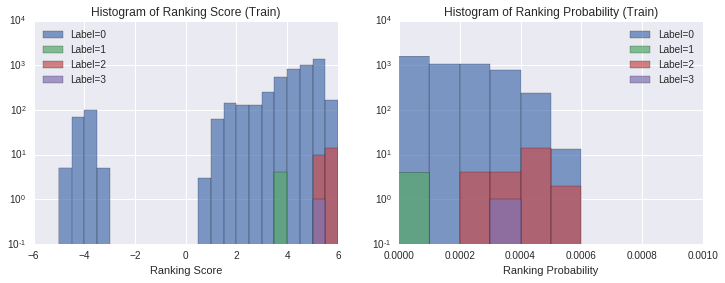

In [166]:
plt.figure(figsize=[12, 4])
ax1 = plt.subplot(1, 2, 1); plt.title('Histogram of Ranking Score (Train)')
#hist1, bins1 = np.histogram(rank_train_['rank'], bins=5)
bins1_train = np.r_[np.arange(rmin1_, rmax1_, 0.5), rmax1_]  # [-1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0]
rank_train_.loc[ix0, 'rank'].hist(ax=ax1, bins=bins1_train, label='Label=0', alpha=0.7)
rank_train_.loc[ix1, 'rank'].hist(ax=ax1, bins=bins1_train, label='Label=1', alpha=0.7)
rank_train_.loc[ix2, 'rank'].hist(ax=ax1, bins=bins1_train, label='Label=2', alpha=0.7)
rank_train_.loc[ix3, 'rank'].hist(ax=ax1, bins=bins1_train, label='Label=3', alpha=0.7)
ax1.set_yscale('log')
ax1.set_ylim(ymin=0.1)
ax1.set_xlabel('Ranking Score')
plt.legend(loc='upper left')

ax2 = plt.subplot(1, 2, 2); plt.title('Histogram of Ranking Probability (Train)')
#hist2, bins2 = np.histogram(rank_train_['probability'], bins=5)
bins2_train = np.r_[np.arange(pmin1_, pmax1_, 0.0001), pmax1_]  # [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
rank_train_.loc[ix0, 'probability'].hist(ax=ax2, bins=bins2_train, label='Label=0', alpha=0.7)
rank_train_.loc[ix1, 'probability'].hist(ax=ax2, bins=bins2_train, label='Label=1', alpha=0.7)
rank_train_.loc[ix2, 'probability'].hist(ax=ax2, bins=bins2_train, label='Label=2', alpha=0.7)
rank_train_.loc[ix3, 'probability'].hist(ax=ax2, bins=bins2_train, label='Label=3', alpha=0.7)
ax2.set_yscale('log')
ax2.set_ylim(ymin=0.1)
ax2.set_xlabel('Ranking Probability')
plt.legend(loc='upper right')
print('NOTE: labels of POI in training set is query specific')

In [51]:
for seqid_idx_ in range(len(seqid_set_test0)):
    seq_ = extract_seq(seqid_set_test0[seqid_idx_], seq_all)
    if len(seq_) > 2:
        print(seq_)
        test_df_ = gen_test_df(seq_[0], seq_[-1], len(seq_), poi_info_t, query_id_dict)
        break

[21, 23, 30]


In [52]:
rank_test_ = ranksvm_.predict(test_df_)
rank_test_.set_index('poiID', inplace=True)
rank_test_.sort_values(by='rank', ascending=False, inplace=True)

Histograms of one test query.

In [53]:
print(test_df_.shape, rank_test_.shape)

(29, 17) (29, 2)


In [54]:
#test_df_['label'].unique()  # 'label' in test set are random numbers (a place holder)

In [55]:
rmin = rank_test_['rank'].min()
rmax = rank_test_['rank'].max()
print(rmin, rmax)
rmin1 = np.round(rmin); rmin1 = rmin1 if rmin1 < rmin else rmin1 - 0.5
rmax1 = np.round(rmax); rmax1 = rmax1 if rmax1 > rmax else rmax1 + 0.5
print(rmin1, rmax1)

-3.75274 5.55332
-4.0 6.0


In [56]:
pmin = rank_test_['probability'].min()
pmax = rank_test_['probability'].max()
print(pmin, pmax)
pmin1 = np.round(pmin); pmin1 = pmin1 if pmin1 < pmin else max(0, pmin1 - 0.5)
pmax1 = np.round(pmax); pmax1 = pmax1 if pmax1 > pmax else min(1, pmax1 + 0.5)
print(pmin1, pmax1)

6.72002752786e-06 0.07395057554
0.0 0.5


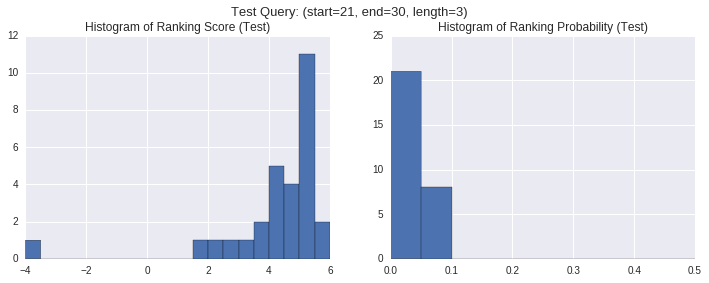

In [57]:
plt.figure(figsize=[12, 4])
plt.suptitle('Test Query: (start=%d, end=%d, length=%d)' % (seq_[0], seq_[-1], len(seq_)), fontsize=13, y=1)

ax1 = plt.subplot(1, 2, 1); plt.title('Histogram of Ranking Score (Test)')
bins1_test = np.r_[np.arange(rmin1, rmax1, 0.5), rmax1]  # [-1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5]
rank_test_['rank'].hist(ax=ax1, bins=bins1_test)

ax2 = plt.subplot(1, 2, 2); plt.title('Histogram of Ranking Probability (Test)')
bins2_test = np.r_[np.arange(pmin1, pmax1, 0.05), pmax1]  # [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
rank_test_['probability'].hist(ax=ax2, bins=bins2_test)

In [58]:
print(rank_test_['probability'].sum())  # it is ranking probabilities, not probability distribution
rank_test_

1.0


,rank,probability
poiID,,
23,5.55332,0.073951
16,5.50072,0.070161
7,5.47484,0.068369
22,5.29216,0.056954
28,5.28848,0.056744
21,5.28381,0.056480
30,5.28021,0.056277
6,5.24899,0.054547
8,5.14857,0.049336


<a id='sec3'></a>

# 3. Factorise Transition Probabilities in POI Feature Space

Estimate a transition matrix for each feature of POI, transition probabilities (matrix) between different POI features (vector) is obtrained by the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) of the individual transition matrix corresponding to each feature.

<a id='sec3.1'></a>

## 3.1 POI Features for Factorisation

POI features used to factorise transition matrix of Markov Chain with POI features (vector) as states:
- Category of POI
- Popularity of POI (discritize with uniform log-scale bins, #bins <=5 )
- The number of POI visits (discritize with uniform log-scale bins, #bins <=5 )
- The average visit duration of POI (discritise with uniform log-scale bins, #bins <= 5)
- The neighborhood relationship between POIs (clustering POI(lat, lon) using k-means, #clusters <= 5)

We count the number of transition first, then normalise each row while taking care of zero by adding each cell a small number (i.e. $0.2$ times the minimum value of that row) if there exists a zero cell.

In [59]:
def normalise_transmat(transmat):
    assert(isinstance(transmat, pd.DataFrame))
    for row in range(transmat.index.shape[0]):
        nonzeroidx = np.nonzero(transmat.iloc[row])[0].tolist()    
        if len(nonzeroidx) < transmat.columns.shape[0]:
            if len(nonzeroidx) == 0:  # all zeros in row
                transmat.iloc[row] = 1 / transmat.columns.shape[0]  # uniform distribution
            else:
                minv = np.min(transmat.iloc[row, nonzeroidx])
                EPS = 0.2 * minv  # row-specific smooth factor
                #zeroidx = list(set(range(len(transmat.columns))) - set(nonzeroidx))
                #transmat.iloc[row, zeroidx] = EPS
                transmat.iloc[row] += EPS
                rowsum = np.sum(transmat.iloc[row])
                assert(rowsum > 0)
                transmat.iloc[row] /= rowsum
        else:
            assert(len(nonzeroidx) == transmat.columns.shape[0])  # all non-zero in row
            transmat.iloc[row] /= np.sum(transmat.iloc[row])
    return transmat

POIs in training set.

In [60]:
poi_train = seq_all[seq_all['seqID'].isin(seqid_set_train0)]['poiID'].unique().tolist()
poi_train.sort()
#poi_train

<a id='sec3.2'></a>

## 3.2 Transition Matrix between POI Cateogries

In [61]:
poi_cats = poi_all.loc[poi_train, 'poiTheme'].unique().tolist()
poi_cats.sort()
poi_cats

['Amusement', 'Beach', 'Cultural', 'Shopping', 'Sport', 'Structure']

In [62]:
transmat_cat = pd.DataFrame(data=np.zeros((len(poi_cats), len(poi_cats)), dtype=np.float), \
                            columns=poi_cats, index=poi_cats)

Count the number of transitions between POI categories.

In [63]:
for seqid in seqid_set_train0:
    seq = extract_seq(seqid, seq_all)
    if len(seq) > 1:
        for pi in range(len(seq)-1):
            p1 = seq[pi]
            p2 = seq[pi+1]
            cat1 = poi_all.loc[p1, 'poiTheme']
            cat2 = poi_all.loc[p2, 'poiTheme']
            transmat_cat.loc[cat1, cat2] += 1

In [64]:
transmat_cat

,Amusement,Beach,Cultural,Shopping,Sport,Structure
Amusement,8,15,30,12,21,14
Beach,10,33,43,60,14,69
Cultural,22,45,31,53,18,64
Shopping,9,61,38,10,11,48
Sport,27,16,15,10,7,18
Structure,20,60,56,37,11,15


Normalise each row to obtain transition probabilities.

In [65]:
transmat_cat = normalise_transmat(transmat_cat)

In [66]:
transmat_cat

,Amusement,Beach,Cultural,Shopping,Sport,Structure
Amusement,0.080000,0.150000,0.300000,0.120000,0.210000,0.140000
Beach,0.043668,0.144105,0.187773,0.262009,0.061135,0.301310
Cultural,0.094421,0.193133,0.133047,0.227468,0.077253,0.274678
Shopping,0.050847,0.344633,0.214689,0.056497,0.062147,0.271186
Sport,0.290323,0.172043,0.161290,0.107527,0.075269,0.193548
Structure,0.100503,0.301508,0.281407,0.185930,0.055276,0.075377


Combine the above steps.

In [67]:
def gen_transmat_cat(seqid_set, seq_all, poi_info):
    #poi_train = seq_all[seq_all['seqID'].isin(seqid_set)]['poiID'].unique().tolist()
    poi_train = poi_info.index.tolist()
    #poi_train.sort()
    poi_cats = poi_info.loc[poi_train, 'poiTheme'].unique().tolist()
    poi_cats.sort()
    transmat_cat = pd.DataFrame(data=np.zeros((len(poi_cats), len(poi_cats)), dtype=np.float), \
                                columns=poi_cats, index=poi_cats)
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        if len(seq) > 1:
            for pi in range(len(seq)-1):
                p1 = seq[pi]
                p2 = seq[pi+1]
                cat1 = poi_all.loc[p1, 'poiTheme']
                cat2 = poi_all.loc[p2, 'poiTheme']
                transmat_cat.loc[cat1, cat2] += 1
    return normalise_transmat(transmat_cat)

<a id='sec3.3'></a>

## 3.3 Transition Matrix between POI Popularity Classes

In [68]:
poi_pops = poi_info_t.loc[poi_train, 'popularity'].unique().tolist()
poi_pops.sort()
poi_pops

[8,
 16,
 19,
 20,
 21,
 22,
 24,
 26,
 30,
 31,
 44,
 66,
 67,
 77,
 88,
 91,
 105,
 118,
 124,
 153,
 154,
 173,
 188,
 196,
 199,
 237,
 242,
 268]

Discretize POI popularity with uniform log-scale bins (#bins $\le 5$).

In [69]:
poi_all['poiFreq'].max()

4142

In [70]:
expo_pop1 = np.log10(min(poi_pops))
expo_pop2 = np.log10(max(poi_pops))
print(expo_pop1, expo_pop2)

0.903089986992 2.42813479403


In [71]:
nbins_pop = 2
logbins_pop = np.logspace(np.floor(expo_pop1), np.ceil(expo_pop2), nbins_pop+1)
logbins_pop

array([    1.       ,    31.6227766,  1000.       ])

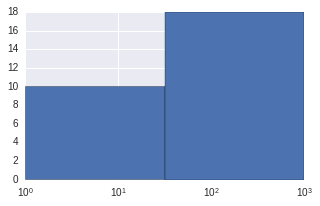

In [72]:
ax = pd.Series(poi_pops).hist(figsize=(5, 3), bins=logbins_pop)
ax.set_xscale('log')

In [73]:
transmat_pop = pd.DataFrame(data=np.zeros((nbins_pop, nbins_pop), dtype=np.float), \
                            columns=np.arange(1, nbins_pop+1), index=np.arange(1, nbins_pop+1))

Count the number of transitions between POI popularity classes.

In [74]:
#np.digitize([101, 0.1], logbins_pop)

In [75]:
for seqid in seqid_set_train0:
    seq = extract_seq(seqid, seq_all)
    if len(seq) > 1:
        for pi in range(len(seq)-1):
            p1 = seq[pi]
            p2 = seq[pi+1]
            pop1 = poi_info_t.loc[p1, 'popularity']
            pop2 = poi_info_t.loc[p2, 'popularity']
            pc1, pc2 = np.digitize([pop1, pop2], logbins_pop)
            transmat_pop.loc[pc1, pc2] += 1

In [76]:
transmat_pop

,1,2
1,15,18
2,20,978


Normalise each row to obtain transition probabilities.

In [77]:
transmat_pop = normalise_transmat(transmat_pop)

In [78]:
transmat_pop

,1,2
1,0.454545,0.545455
2,0.020040,0.979960


Combine the above steps.

In [79]:
def gen_transmat_pop(seqid_set, seq_all, poi_info, nbins=2):
    #poi_train = seq_all[seq_all['seqID'].isin(seqid_set)]['poiID'].unique().tolist()
    poi_train = poi_info.index.tolist()
    #poi_train.sort()
    #poi_info = calc_poi_info(seqid_set, seq_all, poi_all)
    poi_pops = poi_info.loc[poi_train, 'popularity'].unique().tolist()
    poi_pops.sort()
    expo_pop1 = np.log10(min(poi_pops))
    expo_pop2 = np.log10(max(poi_pops))
    logbins_pop = np.logspace(np.floor(expo_pop1), np.ceil(expo_pop2), nbins+1)
    transmat_pop = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        if len(seq) > 1:
            for pi in range(len(seq)-1):
                p1 = seq[pi]
                p2 = seq[pi+1]
                pop1 = poi_info.loc[p1, 'popularity']
                pop2 = poi_info.loc[p2, 'popularity']
                pc1, pc2 = np.digitize([pop1, pop2], logbins_pop)
                transmat_pop.loc[pc1, pc2] += 1
    return normalise_transmat(transmat_pop), logbins_pop

<a id='sec3.4'></a>

## 3.3 Transition Matrix between the Number of POI Visit Classes

In [80]:
poi_visits = poi_info_t.loc[poi_train, 'nVisit'].unique().tolist()
poi_visits.sort()
poi_visits

[8,
 19,
 21,
 24,
 27,
 28,
 30,
 38,
 50,
 52,
 57,
 78,
 100,
 136,
 150,
 157,
 167,
 194,
 229,
 235,
 271,
 272,
 332,
 339,
 340,
 356,
 390,
 435,
 554]

Discretize the number of POI visit with uniform log-scale bins (#bins $\le 5$).

In [81]:
expo_visit1 = np.log10(min(poi_visits))
expo_visit2 = np.log10(max(poi_visits))
print(expo_visit1, expo_visit2)

0.903089986992 2.74350976473


In [82]:
np.floor(expo_visit1)

0.0

In [83]:
nbins_visit = 2
logbins_visit = np.logspace(np.floor(expo_visit1), np.ceil(expo_visit2), nbins_visit+1)
logbins_visit

array([    1.       ,    31.6227766,  1000.       ])

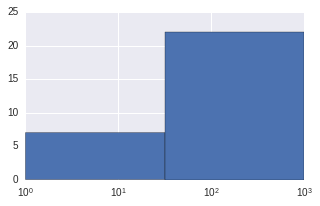

In [84]:
ax = pd.Series(poi_visits).hist(figsize=(5, 3), bins=logbins_visit)
ax.set_xscale('log')

In [85]:
transmat_visit = pd.DataFrame(data=np.zeros((nbins_visit, nbins_visit), dtype=np.float), \
                              columns=np.arange(1, nbins_visit+1), index=np.arange(1, nbins_visit+1))

Count the number of transitions between POI popularity classes.

In [86]:
for seqid in seqid_set_train0:
    seq = extract_seq(seqid, seq_all)
    if len(seq) > 1:
        for pi in range(len(seq)-1):
            p1 = seq[pi]
            p2 = seq[pi+1]
            visit1 = poi_info_t.loc[p1, 'nVisit']
            visit2 = poi_info_t.loc[p2, 'nVisit']
            vc1, vc2 = np.digitize([visit1, visit2], logbins_visit)
            transmat_visit.loc[vc1, vc2] += 1

In [87]:
transmat_visit

,1,2
1,8,14
2,17,992


Normalise each row to obtain transition probabilities.

In [88]:
transmat_visit = normalise_transmat(transmat_visit)

In [89]:
transmat_visit

,1,2
1,0.363636,0.636364
2,0.016848,0.983152


Combine the above steps.

In [90]:
def gen_transmat_visit(seqid_set, seq_all, poi_info, nbins=2):
    #poi_train = seq_all[seq_all['seqID'].isin(seqid_set)]['poiID'].unique().tolist()
    poi_train = poi_info.index.tolist()
    #poi_train.sort()
    #poi_info = calc_poi_info(seqid_set, seq_all, poi_all)
    poi_visits = poi_info.loc[poi_train, 'nVisit'].unique().tolist()
    poi_visits.sort()
    expo_visit1 = np.log10(min(poi_visits))
    expo_visit2 = np.log10(max(poi_visits))
    logbins_visit = np.logspace(np.floor(expo_visit1), np.ceil(expo_visit2), nbins+1)
    transmat_visit = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                  columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        if len(seq) > 1:
            for pi in range(len(seq)-1):
                p1 = seq[pi]
                p2 = seq[pi+1]
                visit1 = poi_info.loc[p1, 'nVisit']
                visit2 = poi_info.loc[p2, 'nVisit']
                vc1, vc2 = np.digitize([visit1, visit2], logbins_visit)
                transmat_visit.loc[vc1, vc2] += 1
    return normalise_transmat(transmat_visit), logbins_visit

<a id='sec3.5'></a>

## 3.5 Transition Matrix between POI Average Visit Duration Classes

In [91]:
poi_durations = poi_info_t.loc[poi_train, 'avgDuration(sec)'].unique().tolist()
poi_durations.sort()
np.round(poi_durations, 2)

array([  455.25,   618.  ,   618.16,   711.16,   783.76,   897.94,
         946.86,  1172.09,  1210.3 ,  1210.48,  1336.69,  1369.45,
        1459.  ,  1508.86,  1581.21,  1648.79,  1666.8 ,  1840.54,
        1998.63,  2348.84,  2416.74,  2426.13,  2513.51,  3010.23,
        3030.08,  3116.94,  4420.  ,  5314.46,  7800.87])

Discretize POI average visit duration with uniform log-scale bins (#bins $\le 5$).

In [92]:
expo_duration1 = np.log10(min(poi_durations))
expo_duration2 = np.log10(max(poi_durations))
print(expo_duration1, expo_duration2)

2.65824995447 3.89214285495


In [93]:
nbins_duration = 2
logbins_duration = np.logspace(np.floor(expo_duration1), np.ceil(expo_duration2), nbins_duration+1)
logbins_duration

array([   100.,   1000.,  10000.])

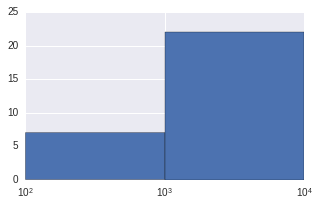

In [94]:
ax = pd.Series(poi_durations).hist(figsize=(5, 3), bins=logbins_duration)
ax.set_xscale('log')

In [95]:
transmat_duration = pd.DataFrame(data=np.zeros((nbins_duration, nbins_duration), dtype=np.float), \
                                 columns=np.arange(1, nbins_duration+1), index=np.arange(1, nbins_duration+1))

Count the number of transitions between POI average visit duration classes.

In [96]:
for seqid in seqid_set_train0:
    seq = extract_seq(seqid, seq_all)
    if len(seq) > 1:
        for pi in range(len(seq)-1):
            p1 = seq[pi]
            p2 = seq[pi+1]
            d1 = poi_info_t.loc[p1, 'avgDuration(sec)']
            d2 = poi_info_t.loc[p2, 'avgDuration(sec)']
            dc1, dc2 = np.digitize([d1, d2], logbins_duration)
            transmat_duration.loc[dc1, dc2] += 1

In [97]:
transmat_duration

,1,2
1,10,118
2,141,762


Normalise each row to obtain transition probabilities.

In [98]:
transmat_duration = normalise_transmat(transmat_duration)

In [99]:
transmat_duration

,1,2
1,0.078125,0.921875
2,0.156146,0.843854


Combine the above steps.

In [100]:
def gen_transmat_duration(seqid_set, seq_all, poi_info, nbins=2):
    #poi_train = seq_all[seq_all['seqID'].isin(seqid_set)]['poiID'].unique().tolist()
    poi_train = poi_info.index.tolist()
    #poi_train.sort()
    #poi_info = calc_poi_info(seqid_set, seq_all, poi_all)
    poi_durations = poi_info.loc[poi_train, 'avgDuration(sec)'].unique().tolist()
    poi_durations.sort()
    expo_duration1 = np.log10(min(poi_durations))
    expo_duration2 = np.log10(max(poi_durations))
    logbins_duration = np.logspace(np.floor(expo_duration1), np.ceil(expo_duration2), nbins+1)
    transmat_duration = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                     columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        if len(seq) > 1:
            for pi in range(len(seq)-1):
                p1 = seq[pi]
                p2 = seq[pi+1]
                d1 = poi_info.loc[p1, 'avgDuration(sec)']
                d2 = poi_info.loc[p2, 'avgDuration(sec)']
                dc1, dc2 = np.digitize([d1, d2], logbins_duration)
                transmat_duration.loc[dc1, dc2] += 1
    return normalise_transmat(transmat_duration), logbins_duration

<a id='sec3.6'></a>

## 3.6 Transition Matrix between POI Neighborhood Classes

Compute POI neighborhoods, i.e., clustering POI (lat, lon) in training set using k-means, #clusters $\le 5$.

KMeans in scikit-learn seems unable to use custom distance metric and no implementation of [Haversine formula](http://en.wikipedia.org/wiki/Great-circle_distance), use Euclidean distance to approximate.

In [101]:
#from sklearn.cluster import KMeans
X = poi_all.loc[poi_train, ['poiLon', 'poiLat']]
nclusters = 5

In [102]:
kmeans = KMeans(n_clusters=nclusters)
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [103]:
clusters = kmeans.predict(X)
clusters

array([3, 0, 3, 3, 3, 3, 3, 4, 3, 3, 1, 3, 0, 3, 3, 0, 0, 3, 0, 3, 3, 3, 3,
       3, 2, 3, 3, 3, 3], dtype=int32)

In [104]:
poi_clusters = pd.DataFrame(data=clusters, index=poi_train)
poi_clusters.index.name = 'poiID'
poi_clusters.rename(columns={0:'clusterID'}, inplace=True)
#poi_clusters

In [105]:
diff = poi_all.loc[poi_train, ['poiLon', 'poiLat']].max() - poi_all.loc[poi_train, ['poiLon', 'poiLat']].min()
diff['poiLon'] / diff['poiLat']

1.3991425640130917

A $3:2$ figure should be fine.

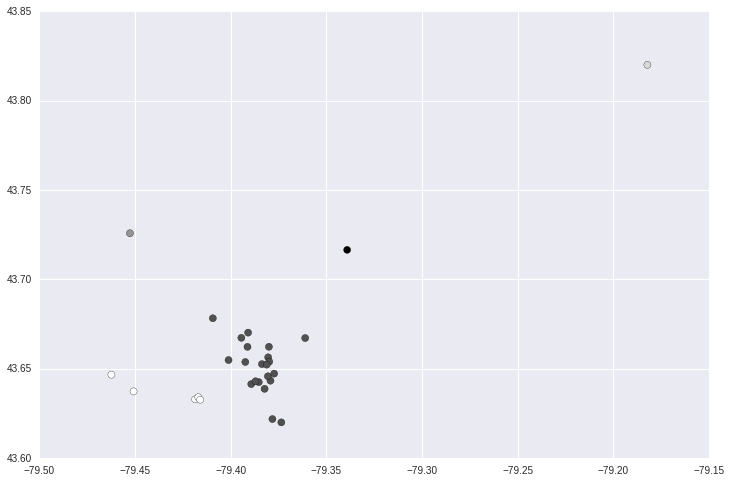

In [106]:
plt.figure(figsize=[12, 8])
plt.scatter(poi_all.loc[poi_train, 'poiLon'], poi_all.loc[poi_train, 'poiLat'], c=clusters, s=50)

In [107]:
transmat_neighbor = pd.DataFrame(data=np.zeros((nclusters, nclusters), dtype=np.float), \
                                 columns=np.arange(nclusters), index=np.arange(nclusters))

Count the number of transitions between POIs in different clusters.

In [108]:
for seqid in seqid_set_train0:
    seq = extract_seq(seqid, seq_all)
    if len(seq) > 1:
        for pi in range(len(seq)-1):
            p1 = seq[pi]
            p2 = seq[pi+1]
            c1 = poi_clusters.loc[p1, 'clusterID']
            c2 = poi_clusters.loc[p2, 'clusterID']
            transmat_neighbor.loc[c1, c2] += 1

In [109]:
transmat_neighbor

,0,1,2,3,4
0,21,0,0,4,0
1,0,0,0,0,0
2,0,0,0,2,0
3,3,0,1,998,1
4,0,0,0,1,0


Normalise each row to obtain transition probabilities.

In [110]:
transmat_neighbor = normalise_transmat(transmat_neighbor)

In [111]:
transmat_neighbor

,0,1,2,3,4
0,0.751724,0.027586,0.027586,0.165517,0.027586
1,0.200000,0.200000,0.200000,0.200000,0.200000
2,0.100000,0.100000,0.100000,0.600000,0.100000
3,0.003187,0.000199,0.001195,0.994223,0.001195
4,0.100000,0.100000,0.100000,0.600000,0.100000


Combine the above steps.

In [112]:
def gen_transmat_neighbor(seqid_set, seq_all, poi_info, nclusters=5):
    #poi_train = seq_all[seq_all['seqID'].isin(seqid_set)]['poiID'].unique().tolist()
    poi_train = poi_info.index.tolist()
    #poi_train.sort()
    X = poi_info.loc[poi_train, ['poiLon', 'poiLat']]
    kmeans = KMeans(n_clusters=nclusters)
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    poi_clusters = pd.DataFrame(data=clusters, index=poi_train)
    poi_clusters.index.name = 'poiID'
    poi_clusters.rename(columns={0:'clusterID'}, inplace=True)
    transmat_neighbor = pd.DataFrame(data=np.zeros((nclusters, nclusters), dtype=np.float), \
                                     columns=np.arange(nclusters), index=np.arange(nclusters))
    for seqid in seqid_set:
        seq = extract_seq(seqid, seq_all)
        if len(seq) > 1:
            for pi in range(len(seq)-1):
                p1 = seq[pi]
                p2 = seq[pi+1]
                c1 = poi_clusters.loc[p1, 'clusterID']
                c2 = poi_clusters.loc[p2, 'clusterID']
                transmat_neighbor.loc[c1, c2] += 1
    return normalise_transmat(transmat_neighbor), poi_clusters

<a id='sec3.7'></a>

## 3.7 Transition Matrix between POIs

Approximate transition probabilities (matrix) between different POI features (vector) using the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) of individual transition matrix corresponding to each feature, i.e., POI category, POI popularity (discritized), POI average visit duration (discritized) and POI neighborhoods (clusters).

In [113]:
#from scipy.linalg import kron
transmat_value = transmat_cat.values
for transmat in [transmat_pop, transmat_visit, transmat_duration, transmat_neighbor]:
    transmat_value = kron(transmat_value, transmat.values)

Index of Kronecker product.

In [114]:
transmat_ix = list(itertools.product(transmat_cat.index, transmat_pop.index, transmat_visit.index, \
                                     transmat_duration.index, transmat_neighbor.index))

In [115]:
transmat_feature = pd.DataFrame(data=transmat_value, index=transmat_ix, columns=transmat_ix)
transmat_feature.index.name = '(poiTheme, popularity, avgDuration, clusterID)'
#transmat_feature.head()

In [116]:
print(transmat_cat.shape)
print(transmat_pop.shape)
print(transmat_visit.shape)
print(transmat_duration.shape)
print(transmat_neighbor.shape)
print(transmat_feature.shape)

(6, 6)
(2, 2)
(2, 2)
(2, 2)
(5, 5)
(240, 240)


In [117]:
transmat_feature.head()

,"(Amusement, 1, 1, 1, 0)","(Amusement, 1, 1, 1, 1)","(Amusement, 1, 1, 1, 2)","(Amusement, 1, 1, 1, 3)","(Amusement, 1, 1, 1, 4)","(Amusement, 1, 1, 2, 0)","(Amusement, 1, 1, 2, 1)","(Amusement, 1, 1, 2, 2)","(Amusement, 1, 1, 2, 3)","(Amusement, 1, 1, 2, 4)",...,"(Structure, 2, 2, 1, 0)","(Structure, 2, 2, 1, 1)","(Structure, 2, 2, 1, 2)","(Structure, 2, 2, 1, 3)","(Structure, 2, 2, 1, 4)","(Structure, 2, 2, 2, 0)","(Structure, 2, 2, 2, 1)","(Structure, 2, 2, 2, 2)","(Structure, 2, 2, 2, 3)","(Structure, 2, 2, 2, 4)"
"(poiTheme, popularity, avgDuration, clusterID)",,,,,,,,,,,,,,,,,,,,,
"(Amusement, 1, 1, 1, 0)",0.000777,2.849815e-05,0.000028,0.000171,0.000028,0.009164,0.000336,0.000336,0.002018,0.000336,...,0.002854,1.047307e-04,0.000105,0.000628,0.000105,0.033676,0.001236,0.001236,0.007415,0.001236
"(Amusement, 1, 1, 1, 1)",0.000207,2.066116e-04,0.000207,0.000207,0.000207,0.002438,0.002438,0.002438,0.002438,0.002438,...,0.000759,7.592975e-04,0.000759,0.000759,0.000759,0.008960,0.008960,0.008960,0.008960,0.008960
"(Amusement, 1, 1, 1, 2)",0.000103,1.033058e-04,0.000103,0.000620,0.000103,0.001219,0.001219,0.001219,0.007314,0.001219,...,0.000380,3.796488e-04,0.000380,0.002278,0.000380,0.004480,0.004480,0.004480,0.026879,0.004480
"(Amusement, 1, 1, 1, 3)",0.000003,2.057884e-07,0.000001,0.001027,0.000001,0.000039,0.000002,0.000015,0.012120,0.000015,...,0.000012,7.562724e-07,0.000005,0.003775,0.000005,0.000143,0.000009,0.000054,0.044540,0.000054
"(Amusement, 1, 1, 1, 4)",0.000103,1.033058e-04,0.000103,0.000620,0.000103,0.001219,0.001219,0.001219,0.007314,0.001219,...,0.000380,3.796488e-04,0.000380,0.002278,0.000380,0.004480,0.004480,0.004480,0.026879,0.004480


The result of [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) should be normalised to obtain transition probabilities.

In [118]:
#from scipy.misc import logsumexp
logtransmat_feature = np.log(transmat_feature)
for row in range(logtransmat_feature.shape[0]):
    logtransmat_feature.iloc[row] -= logsumexp(logtransmat_feature.iloc[row])
logtransmat_feature.head()

,"(Amusement, 1, 1, 1, 0)","(Amusement, 1, 1, 1, 1)","(Amusement, 1, 1, 1, 2)","(Amusement, 1, 1, 1, 3)","(Amusement, 1, 1, 1, 4)","(Amusement, 1, 1, 2, 0)","(Amusement, 1, 1, 2, 1)","(Amusement, 1, 1, 2, 2)","(Amusement, 1, 1, 2, 3)","(Amusement, 1, 1, 2, 4)",...,"(Structure, 2, 2, 1, 0)","(Structure, 2, 2, 1, 1)","(Structure, 2, 2, 1, 2)","(Structure, 2, 2, 1, 3)","(Structure, 2, 2, 1, 4)","(Structure, 2, 2, 2, 0)","(Structure, 2, 2, 2, 1)","(Structure, 2, 2, 2, 2)","(Structure, 2, 2, 2, 3)","(Structure, 2, 2, 2, 4)"
"(poiTheme, popularity, avgDuration, clusterID)",,,,,,,,,,,,,,,,,,,,,
"(Amusement, 1, 1, 1, 0)",-7.160618,-10.465671,-10.465671,-8.673912,-10.465671,-4.692518,-7.997572,-7.997572,-6.205812,-7.997572,...,-5.859065,-9.164118,-9.164118,-7.372359,-9.164118,-3.390965,-6.696019,-6.696019,-4.904259,-6.696019
"(Amusement, 1, 1, 1, 1)",-8.484670,-8.484670,-8.484670,-8.484670,-8.484670,-6.016570,-6.016570,-6.016570,-6.016570,-6.016570,...,-7.183117,-7.183117,-7.183117,-7.183117,-7.183117,-4.715017,-4.715017,-4.715017,-4.715017,-4.715017
"(Amusement, 1, 1, 1, 2)",-9.177817,-9.177817,-9.177817,-7.386058,-9.177817,-6.709718,-6.709718,-6.709718,-4.917958,-6.709718,...,-7.876264,-7.876264,-7.876264,-6.084505,-7.876264,-5.408165,-5.408165,-5.408165,-3.616405,-5.408165
"(Amusement, 1, 1, 1, 3)",-12.623829,-15.396417,-13.604658,-6.881026,-13.604658,-10.155729,-12.928318,-11.136558,-4.412926,-11.136558,...,-11.322275,-14.094864,-12.303105,-5.579473,-12.303105,-8.854176,-11.626765,-9.835005,-3.111373,-9.835005
"(Amusement, 1, 1, 1, 4)",-9.177817,-9.177817,-9.177817,-7.386058,-9.177817,-6.709718,-6.709718,-6.709718,-4.917958,-6.709718,...,-7.876264,-7.876264,-7.876264,-6.084505,-7.876264,-5.408165,-5.408165,-5.408165,-3.616405,-5.408165


In [119]:
logtransmat_feature.max().sort_values(ascending=False).head(10)

(Beach, 2, 2, 2, 3)       -1.189651
(Structure, 2, 2, 2, 3)   -1.323990
(Cultural, 2, 2, 2, 3)    -1.328348
(Amusement, 2, 2, 2, 3)   -1.361137
(Shopping, 2, 2, 2, 3)    -1.463752
(Beach, 2, 2, 2, 0)       -1.469243
(Structure, 2, 2, 2, 0)   -1.603583
(Cultural, 2, 2, 2, 0)    -1.607940
(Amusement, 2, 2, 2, 0)   -1.640730
(Sport, 2, 2, 2, 3)       -1.685023
dtype: float64

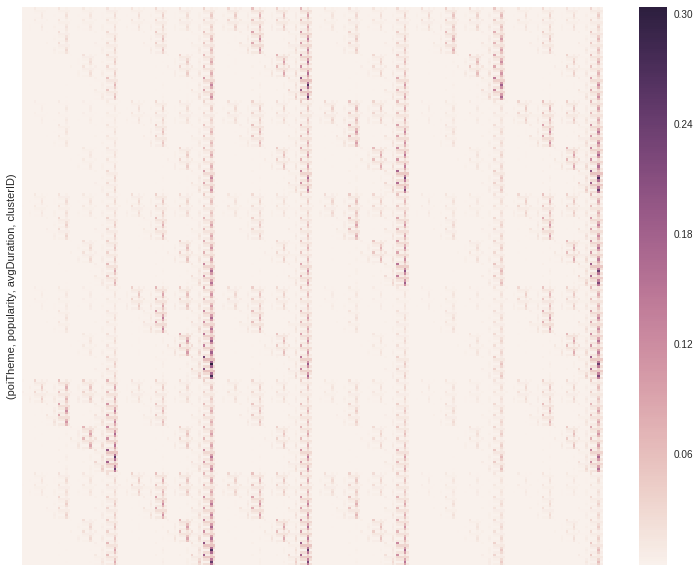

In [120]:
plt.figure(figsize=[13, 10])
sns.heatmap(np.exp(logtransmat_feature), xticklabels=False, yticklabels=False)

Deal with features without corresponding POIs and feature with more than one corresponding POIs. (*Before Normalisation*)
- For features without corresponding POIs, just remove the rows and columns from the matrix obtained by Kronecker product.
- For different POIs with the exact same feature, 
  - Let POIs with the same feature as a POI group,
  - The *incoming* **transition value (i.e., unnormalised transition probability)** of this POI group 
    should be divided uniformly among the group members, 
    *which corresponds to choose a group member uniformly at random in the incoming case*.
  - The *outgoing* transition value should be duplicated (i.e., the same) among all group members, 
    **as we were already in that group in the outgoing case**.
  - For each POI in the group, the allocation transition value of the *self-loop of the POI group* is similar to 
    that in the *outgoing* case, **as we were already in that group**, so just duplicate and then divide uniformly among 
    the transitions from this POI to other POIs in the same group, 
    *which corresponds to choose a outgoing transition uniformly at random from all outgoing transitions
    excluding the self-loop of this POI*.
- **Concretely**, for a POI group with $n$ POIs, 
    1. If the *incoming* transition value of POI group is $m_1$,
       then the corresponding *incoming* transition value for each group member is $\frac{m_1}{n}$.
    1. If the *outgoing* transition value of POI group is $m_2$,
       then the corresponding *outgoing* transition value for each group member is also $m_2$.
    1. If the transition value of *self-loop of the POI group* is $m_3$,
       then transition value of *self-loop of individual POIs* should be $0$,  
       and *other in-group transitions* with value $\frac{m_3}{n-1}$
       as the total number of outgoing transitions to other POIs in the same group is $n-1$ (excluding the self-loop),
       i.e. $n-1$ choose $1$.
       
**NOTE**: execute the above division before or after row normalisation will lead to the same result, *as the division itself does NOT change the normalising constant of each row (i.e., the sum of each row before normalising)*.

In [121]:
feature_names = ['poiTheme', 'popularity', 'nVisit', 'avgDuration', 'clusterID']
poi_features = pd.DataFrame(data=np.zeros((len(poi_train), len(feature_names))), \
                            columns=feature_names, index=poi_train)
poi_features.index.name = 'poiID'

In [122]:
poi_features['poiTheme'] = poi_info_t.loc[poi_train, 'poiTheme']
poi_features['popularity'] = np.digitize(poi_info_t.loc[poi_train, 'popularity'], logbins_pop)
poi_features['nVisit'] = np.digitize(poi_info_t.loc[poi_train, 'nVisit'], logbins_visit)
poi_features['avgDuration'] = np.digitize(poi_info_t.loc[poi_train, 'avgDuration(sec)'], logbins_duration)
poi_features['clusterID'] = poi_clusters.loc[poi_train, 'clusterID']

In [123]:
#poi_features.duplicated()

In [124]:
ix = transmat_feature.index[0]; ix1 = transmat_feature.index[1]
# simply use df.loc[tuple,:] will trigger an error as pandas treat the tuple as multiindex
# see https://github.com/pydata/pandas/issues/7548
#transmat_feature.loc[(ix,),]   # OK
#transmat_feature.loc[(ix,),:]  # OK
transmat_feature.loc[(ix,), (ix1,)] 

,"(Amusement, 1, 1, 1, 1)"
"(poiTheme, popularity, avgDuration, clusterID)",
"(Amusement, 1, 1, 1, 0)",0.000028


In [125]:
poi_logtransmat = pd.DataFrame(data=np.zeros((len(poi_train), len(poi_train)), dtype=np.float), \
                               columns=poi_train, index=poi_train)

Copy transition values between features with corresponding POIs.

In [126]:
for p1 in poi_logtransmat.index:
    rix = tuple(poi_features.loc[p1])
    for p2 in poi_logtransmat.columns:
        cix = tuple(poi_features.loc[p2])
        value_ = transmat_feature.loc[(rix,), (cix,)]
        #print(value_.values)
        poi_logtransmat.loc[p1, p2] = value_.values[0, 0]

In [127]:
poi_logtransmat.head(11)

,1,2,3,4,6,7,8,9,10,11,...,21,22,23,24,25,26,27,28,29,30
1,0.060841,0.000195,0.060841,0.060841,0.130373,0.130373,0.130373,5.492629e-08,0.002666,0.130373,...,0.139065,0.139065,0.086915,0.086915,0.086915,3.661753e-08,0.016083,0.028949,0.156448,0.156448
2,0.010129,0.046001,0.010129,0.010129,0.021704,0.021704,0.021704,1.267724e-06,0.000444,0.021704,...,0.023151,0.023151,0.014470,0.014470,0.014470,8.451494e-07,0.002677,0.004819,0.026045,0.026045
3,0.060841,0.000195,0.060841,0.060841,0.130373,0.130373,0.130373,5.492629e-08,0.002666,0.130373,...,0.139065,0.139065,0.086915,0.086915,0.086915,3.661753e-08,0.016083,0.028949,0.156448,0.156448
4,0.060841,0.000195,0.060841,0.060841,0.130373,0.130373,0.130373,5.492629e-08,0.002666,0.130373,...,0.139065,0.139065,0.086915,0.086915,0.086915,3.661753e-08,0.016083,0.028949,0.156448,0.156448
6,0.062445,0.000200,0.062445,0.062445,0.107544,0.107544,0.107544,4.530830e-08,0.002199,0.107544,...,0.156112,0.156112,0.183865,0.183865,0.183865,7.746257e-08,0.034022,0.041084,0.222026,0.222026
7,0.062445,0.000200,0.062445,0.062445,0.107544,0.107544,0.107544,4.530830e-08,0.002199,0.107544,...,0.156112,0.156112,0.183865,0.183865,0.183865,7.746257e-08,0.034022,0.041084,0.222026,0.222026
8,0.062445,0.000200,0.062445,0.062445,0.107544,0.107544,0.107544,4.530830e-08,0.002199,0.107544,...,0.156112,0.156112,0.183865,0.183865,0.183865,7.746257e-08,0.034022,0.041084,0.222026,0.222026
9,0.013577,0.002263,0.013577,0.013577,0.023382,0.023382,0.023382,1.855742e-03,0.019485,0.023382,...,0.033942,0.033942,0.039976,0.039976,0.039976,3.172720e-03,0.007397,0.008932,0.048273,0.048273
10,0.034757,0.000111,0.034757,0.034757,0.059860,0.059860,0.059860,1.027675e-06,0.049883,0.059860,...,0.086893,0.086893,0.102341,0.102341,0.102341,1.756992e-06,0.018937,0.022867,0.123582,0.123582
11,0.062445,0.000200,0.062445,0.062445,0.107544,0.107544,0.107544,4.530830e-08,0.002199,0.107544,...,0.156112,0.156112,0.183865,0.183865,0.183865,7.746257e-08,0.034022,0.041084,0.222026,0.222026


Deal with POI features that correspond to more than once POIs.

In [128]:
features_dup = dict()
for poi in poi_features.index:
    key = tuple(poi_features.loc[poi])
    if key in features_dup:
        features_dup[key].append(poi)
    else:
        features_dup[key] = [poi]
features_dup

{('Amusement', 1, 1, 1, 0): [14, 18],
 ('Amusement', 1, 1, 1, 3): [15],
 ('Amusement', 1, 1, 2, 0): [17],
 ('Amusement', 2, 2, 2, 3): [16],
 ('Beach', 1, 1, 1, 0): [20],
 ('Beach', 1, 2, 1, 3): [19],
 ('Beach', 2, 2, 2, 3): [21, 22],
 ('Cultural', 1, 1, 2, 4): [9],
 ('Cultural', 1, 2, 2, 1): [12],
 ('Cultural', 1, 2, 2, 3): [10],
 ('Cultural', 2, 2, 2, 3): [6, 7, 8, 11, 13],
 ('Shopping', 1, 1, 2, 2): [26],
 ('Shopping', 2, 2, 1, 3): [27],
 ('Shopping', 2, 2, 2, 3): [23, 24, 25],
 ('Sport', 2, 2, 2, 0): [2],
 ('Sport', 2, 2, 2, 3): [1, 3, 4],
 ('Structure', 2, 2, 1, 3): [28],
 ('Structure', 2, 2, 2, 3): [29, 30]}

In [129]:
for feature in sorted(features_dup.keys()):
    n = len(features_dup[feature])
    if n > 1:
        group = features_dup[feature]
        v1 = poi_logtransmat.loc[group[0], group[0]]  # transition value of self-loop of POI group
        
        # divide incoming transition value (i.e. unnormalised transition probability) uniformly among group members
        for poi in group:
            poi_logtransmat[poi] /= n
        
        # outgoing transition value has already been duplicated (value copied above)
        
        # duplicate & divide transition value of self-loop of POI group uniformly among all outgoing transitions,
        # from a POI to all other POIs in the same group (excluding POI self-loop)
        v2 = v1 / (n - 1)
        for pair in itertools.permutations(group, 2):
            poi_logtransmat.loc[pair[0], pair[1]] = v2

Make the transition value of all self-loops of POIs to $0$.

In [130]:
for p1 in poi_logtransmat.index:
    poi_logtransmat.loc[p1, p1] = 0

In [131]:
poi_logtransmat.head(11)

,1,2,3,4,6,7,8,9,10,11,...,21,22,23,24,25,26,27,28,29,30
1,0.000000,0.000195,0.030420,0.030420,0.026075,0.026075,0.026075,5.492629e-08,0.002666,0.026075,...,0.069532,0.069532,0.028972,0.028972,0.028972,3.661753e-08,0.016083,0.028949,0.078224,0.078224
2,0.003376,0.000000,0.003376,0.003376,0.004341,0.004341,0.004341,1.267724e-06,0.000444,0.004341,...,0.011576,0.011576,0.004823,0.004823,0.004823,8.451494e-07,0.002677,0.004819,0.013023,0.013023
3,0.030420,0.000195,0.000000,0.030420,0.026075,0.026075,0.026075,5.492629e-08,0.002666,0.026075,...,0.069532,0.069532,0.028972,0.028972,0.028972,3.661753e-08,0.016083,0.028949,0.078224,0.078224
4,0.030420,0.000195,0.030420,0.000000,0.026075,0.026075,0.026075,5.492629e-08,0.002666,0.026075,...,0.069532,0.069532,0.028972,0.028972,0.028972,3.661753e-08,0.016083,0.028949,0.078224,0.078224
6,0.020815,0.000200,0.020815,0.020815,0.000000,0.026886,0.026886,4.530830e-08,0.002199,0.026886,...,0.078056,0.078056,0.061288,0.061288,0.061288,7.746257e-08,0.034022,0.041084,0.111013,0.111013
7,0.020815,0.000200,0.020815,0.020815,0.026886,0.000000,0.026886,4.530830e-08,0.002199,0.026886,...,0.078056,0.078056,0.061288,0.061288,0.061288,7.746257e-08,0.034022,0.041084,0.111013,0.111013
8,0.020815,0.000200,0.020815,0.020815,0.026886,0.026886,0.000000,4.530830e-08,0.002199,0.026886,...,0.078056,0.078056,0.061288,0.061288,0.061288,7.746257e-08,0.034022,0.041084,0.111013,0.111013
9,0.004526,0.002263,0.004526,0.004526,0.004676,0.004676,0.004676,0.000000e+00,0.019485,0.004676,...,0.016971,0.016971,0.013325,0.013325,0.013325,3.172720e-03,0.007397,0.008932,0.024137,0.024137
10,0.011586,0.000111,0.011586,0.011586,0.011972,0.011972,0.011972,1.027675e-06,0.000000,0.011972,...,0.043447,0.043447,0.034114,0.034114,0.034114,1.756992e-06,0.018937,0.022867,0.061791,0.061791
11,0.020815,0.000200,0.020815,0.020815,0.026886,0.026886,0.026886,4.530830e-08,0.002199,0.000000,...,0.078056,0.078056,0.061288,0.061288,0.061288,7.746257e-08,0.034022,0.041084,0.111013,0.111013


Normalise and compute log probability.

In [132]:
for p1 in poi_logtransmat.index:
    rowsum = poi_logtransmat.loc[p1].sum()
    assert(rowsum > 0)
    logrowsum = np.log10(rowsum)
    for p2 in poi_logtransmat.columns:
        if p1 == p2:
            poi_logtransmat.loc[p1, p2] = -np.inf  # deal with log(0) explicitly
        else:
            poi_logtransmat.loc[p1, p2] = np.log10(poi_logtransmat.loc[p1, p2]) - logrowsum

In [133]:
poi_logtransmat.head(11)

,1,2,3,4,6,7,8,9,10,11,...,21,22,23,24,25,26,27,28,29,30
1,-inf,-3.642726,-1.449689,-1.449689,-1.516635,-1.516635,-1.516635,-7.193073,-2.506974,-1.516635,...,-1.090667,-1.090667,-1.470878,-1.470878,-1.470878,-7.369165,-1.726493,-1.471220,-1.039514,-1.039514
2,-1.626157,-inf,-1.626157,-1.626157,-1.517013,-1.517013,-1.517013,-5.051566,-2.507352,-1.517013,...,-1.091044,-1.091044,-1.471255,-1.471255,-1.471255,-5.227657,-1.726870,-1.471597,-1.039891,-1.039891
3,-1.449689,-3.642726,-inf,-1.449689,-1.516635,-1.516635,-1.516635,-7.193073,-2.506974,-1.516635,...,-1.090667,-1.090667,-1.470878,-1.470878,-1.470878,-7.369165,-1.726493,-1.471220,-1.039514,-1.039514
4,-1.449689,-3.642726,-1.449689,-inf,-1.516635,-1.516635,-1.516635,-7.193073,-2.506974,-1.516635,...,-1.090667,-1.090667,-1.470878,-1.470878,-1.470878,-7.369165,-1.726493,-1.471220,-1.039514,-1.039514
6,-1.629262,-3.646208,-1.629262,-1.629262,-inf,-1.518112,-1.518112,-7.291460,-2.605360,-1.518112,...,-1.055231,-1.055231,-1.160259,-1.160259,-1.160259,-7.058545,-1.415873,-1.333969,-0.902263,-0.902263
7,-1.629262,-3.646208,-1.629262,-1.629262,-1.518112,-inf,-1.518112,-7.291460,-2.605360,-1.518112,...,-1.055231,-1.055231,-1.160259,-1.160259,-1.160259,-7.058545,-1.415873,-1.333969,-0.902263,-0.902263
8,-1.629262,-3.646208,-1.629262,-1.629262,-1.518112,-1.518112,-inf,-7.291460,-2.605360,-1.518112,...,-1.055231,-1.055231,-1.160259,-1.160259,-1.160259,-7.058545,-1.415873,-1.333969,-0.902263,-0.902263
9,-1.704154,-2.005184,-1.704154,-1.704154,-1.689913,-1.689913,-1.689913,-inf,-1.070125,-1.689913,...,-1.130123,-1.130123,-1.235150,-1.235150,-1.235150,-1.858400,-1.490765,-1.408861,-0.977155,-0.977155
10,-1.639673,-3.656620,-1.639673,-1.639673,-1.625433,-1.625433,-1.625433,-5.691743,-inf,-1.625433,...,-1.065642,-1.065642,-1.170670,-1.170670,-1.170670,-5.458829,-1.426285,-1.344381,-0.912675,-0.912675
11,-1.629262,-3.646208,-1.629262,-1.629262,-1.518112,-1.518112,-1.518112,-7.291460,-2.605360,-inf,...,-1.055231,-1.055231,-1.160259,-1.160259,-1.160259,-7.058545,-1.415873,-1.333969,-0.902263,-0.902263


Plot transition matrix heatmap.

In [134]:
prob_mat = np.power(10, poi_logtransmat)

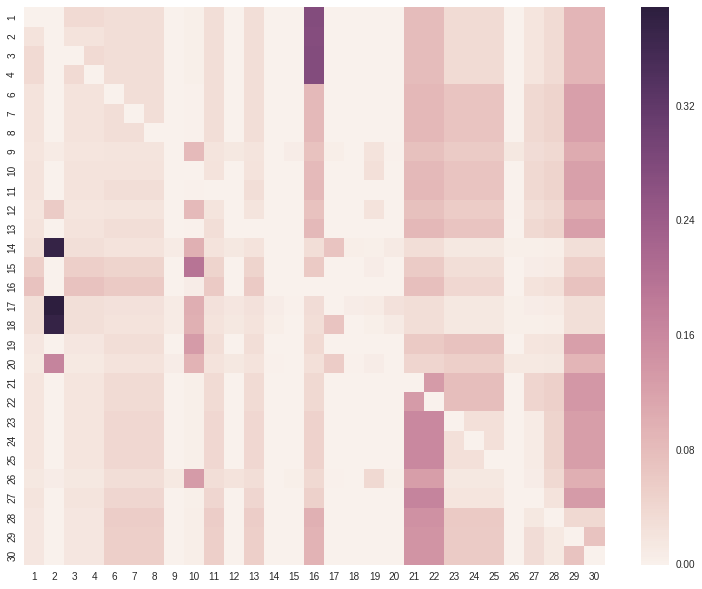

In [135]:
plt.figure(figsize=[13, 10])
#plt.imshow(prob_mat, interpolation='none', cmap=plt.cm.hot)  # OK
#ticks = prob_mat.index
#plt.xticks(np.arange(prob_mat.shape[0]), ticks)
#plt.yticks(np.arange(prob_mat.shape[0]), ticks)
#plt.xlabel('POI ID')
#plt.ylabel('POI ID')
sns.heatmap(prob_mat)

In [136]:
prob_mat.loc[2, 17]

0.00043558556236812938

In [137]:
prob_mat.loc[14, 2]

0.37700970988393417

In [138]:
prob_mat.loc[17, 2]

0.3894316832484036

In [139]:
prob_mat.loc[27, 19]

0.00058089842293407084

In [140]:
prob_mat.loc[15, 19]

0.0082518249705588933

In [141]:
poi_all.loc[[2, 17]]

,poiTheme,poiFreq,poiLon,poiLat
poiID,,,,
2,Sport,609,-79.418634,43.632772
17,Amusement,808,-79.416011,43.632563


In [142]:
d_ = calc_dist(poi_all.loc[2, 'poiLon'], poi_all.loc[2, 'poiLat'], poi_all.loc[17, 'poiLon'], poi_all.loc[17, 'poiLat'])
print('Distance between POI %d and %d is %.3f km.' % (2, 17, d_))

Distance between POI 2 and 17 is 0.212 km.


Combine the above steps.

In [143]:
def gen_poi_logtransmat(seqid_set, seq_all, poi_info, nbins_pop=2, nbins_visit=2, nbins_duration=2, nclusters=5):
    transmat_cat                        = gen_transmat_cat(seqid_set, seq_all, poi_info)
    transmat_pop,      logbins_pop      = gen_transmat_pop(seqid_set, seq_all, poi_info, nbins_pop)
    transmat_visit,    logbins_visit    = gen_transmat_visit(seqid_set, seq_all, poi_info, nbins_visit)
    transmat_duration, logbins_duration = gen_transmat_duration(seqid_set, seq_all, poi_info, nbins_duration)
    transmat_neighbor, poi_clusters     = gen_transmat_neighbor(seqid_set, seq_all, poi_info, nclusters)

    # Kronecker product
    transmat_ix = list(itertools.product(transmat_cat.index, transmat_pop.index, transmat_visit.index, \
                                         transmat_duration.index, transmat_neighbor.index))
    transmat_value = transmat_cat.values
    for transmat in [transmat_pop, transmat_visit, transmat_duration, transmat_neighbor]:
        transmat_value = kron(transmat_value, transmat.values)
    transmat_feature = pd.DataFrame(data=transmat_value, index=transmat_ix, columns=transmat_ix)
    
    #poi_train = seq_all[seq_all['seqID'].isin(seqid_set)]['poiID'].unique().tolist()
    poi_train = poi_info.index.tolist()
    #poi_train.sort()
    #poi_info = calc_poi_info(seqid_set, seq_all, poi_all)
    feature_names = ['poiTheme', 'popularity', 'nVisit', 'avgDuration', 'clusterID']
    poi_features = pd.DataFrame(data=np.zeros((len(poi_train), len(feature_names))), \
                                columns=feature_names, index=poi_train)
    poi_features.index.name = 'poiID'
    poi_features['poiTheme'] = poi_info.loc[poi_train, 'poiTheme']
    poi_features['popularity'] = np.digitize(poi_info.loc[poi_train, 'popularity'], logbins_pop)
    poi_features['nVisit'] = np.digitize(poi_info.loc[poi_train, 'nVisit'], logbins_visit)
    poi_features['avgDuration'] = np.digitize(poi_info.loc[poi_train, 'avgDuration(sec)'], logbins_duration)
    poi_features['clusterID'] = poi_clusters.loc[poi_train, 'clusterID']
    
    # shrink the result of Kronecker product and deal with POIs with the same features
    poi_logtransmat = pd.DataFrame(data=np.zeros((len(poi_train), len(poi_train)), dtype=np.float), \
                                   columns=poi_train, index=poi_train)
    for p1 in poi_logtransmat.index:
        rix = tuple(poi_features.loc[p1])
        for p2 in poi_logtransmat.columns:
            cix = tuple(poi_features.loc[p2])
            value_ = transmat_feature.loc[(rix,), (cix,)]
            poi_logtransmat.loc[p1, p2] = value_.values[0, 0]
    
    # group POIs with the same features
    features_dup = dict()
    for poi in poi_features.index:
        key = tuple(poi_features.loc[poi])
        if key in features_dup:
            features_dup[key].append(poi)
        else:
            features_dup[key] = [poi]
            
    # deal with POIs with the same features
    for feature in sorted(features_dup.keys()):
        n = len(features_dup[feature])
        if n > 1:
            group = features_dup[feature]
            v1 = poi_logtransmat.loc[group[0], group[0]]  # transition value of self-loop of POI group
            
            # divide incoming transition value (i.e. unnormalised transition probability) uniformly among group members
            for poi in group:
                poi_logtransmat[poi] /= n
                
            # outgoing transition value has already been duplicated (value copied above)
            
            # duplicate & divide transition value of self-loop of POI group uniformly among all outgoing transitions,
            # from a POI to all other POIs in the same group (excluding POI self-loop)
            v2 = v1 / (n - 1)
            for pair in itertools.permutations(group, 2):
                poi_logtransmat.loc[pair[0], pair[1]] = v2
                            
    # normalise each row
    for p1 in poi_logtransmat.index:
        poi_logtransmat.loc[p1, p1] = 0
        rowsum = poi_logtransmat.loc[p1].sum()
        assert(rowsum > 0)
        logrowsum = np.log10(rowsum)
        for p2 in poi_logtransmat.columns:
            if p1 == p2:
                poi_logtransmat.loc[p1, p2] = -np.inf  # deal with log(0) explicitly
            else:
                poi_logtransmat.loc[p1, p2] = np.log10(poi_logtransmat.loc[p1, p2]) - logrowsum
    return poi_logtransmat

<a id='sec4'></a>

# 4. Combine Ranking with Factorised Markov Chain to Recommend

NOTE that:
- Ranking is over POIs (in POI space)
- Transition probabilities of Markov Chain of POI features (in POI feature space)

Two approaches to combine ranking with MC:
- recommend trajectory in POI space: 
  - transform transition matrix of feature vector into transition matrix of POIs,
  - recommend a sequence of POIs.
- recommend trajectory in POI feature space: 
  - transform ranking probability of POIs into ranking probability of POI features,
  - recommend a sequence of features, 
  - transform the squence of features into a sequence of POIs.

Here we implement the first approach, i.e., recommend trajectory in POI space.

Two methods for recommendation:
- find a simple path with maximum objective in a digraph. (by negating log probabilities, it can be reduced to a finding shortest path will $k$-edges, which is probably NP-hard as it is the same as TSP when $L=|P|$, dynamic programming can be used for non-simple path.)
- make greedy choice (of POI or POI feature vector) step-by-step

Here we use dynamic programming to find a possibly non-simple path.

In [144]:
def find_path(V, E, ps, pe, L):
    assert(isinstance(V, pd.DataFrame))
    assert(isinstance(E, pd.DataFrame))
    assert(ps in V.index)
    assert(pe in V.index)
    assert(2 < L <= V.index.shape[0])
    
    A = pd.DataFrame(data=np.zeros((L-1, V.shape[0]), dtype=np.float), columns=V.index, index=np.arange(2, L+1))
    B = pd.DataFrame(data=np.zeros((L-1, V.shape[0]), dtype=np.int),   columns=V.index, index=np.arange(2, L+1))
    A += np.inf
    for v in V.index:
        if v != ps:
            A.loc[2, v] = E.loc[ps, v] + V.loc[ps, 'weight'] + V.loc[v, 'weight']  # ps--v
            B.loc[2, v] = ps
    
    for l in range(3, L+1):
        for v in V.index:
            values = [A.loc[l-1, v1] + E.loc[v1, v] + V.loc[v, 'weight'] for v1 in V.index]  # ps-~-v1---v
            minix = np.argmin(values)
            A.loc[l, v] = values[minix]
            B.loc[l, v] = V.index[minix]
            
    path = [pe]
    v = path[-1]
    l = L
    #while v != ps:  #incorrect if 'ps' happens to appear in the middle of a path
    while l >= 2:
        path.append(B.loc[l, v])
        v = path[-1]
        l -= 1
    path.reverse()
    return path

Find a simple path using ILP.

In [145]:
def find_path_ILP(V, E, ps, pe, L):
    assert(isinstance(V, pd.DataFrame))
    assert(isinstance(E, pd.DataFrame))
    assert(ps in V.index)
    assert(pe in V.index)
    assert(2 < L <= V.index.shape[0])
    
    p0 = str(ps); pN = str(pe); N = V.index.shape[0]
    
    # deal with np.inf which will cause ILP solver failure
    Edges = E.copy()
    INF = 1e6
    for p in Edges.index:
        Edges.loc[p, p] = INF 
    maxL = np.max(Edges.values.flatten())
    if maxL > INF:
        for p in Edges.index:
            Edges.loc[p, p] = maxL    
    
    # REF: pythonhosted.org/PuLP/index.html
    pois = [str(p) for p in V.index] # create a string list for each POI
    pb = pulp.LpProblem('MostLikelyTraj', pulp.LpMinimize) # create problem
    # visit_i_j = 1 means POI i and j are visited in sequence
    visit_vars = pulp.LpVariable.dicts('visit', (pois, pois), 0, 1, pulp.LpInteger) 
    # a dictionary contains all dummy variables
    dummy_vars = pulp.LpVariable.dicts('u', [x for x in pois if x != p0], 2, N, pulp.LpInteger)
    
    # add objective
    objlist = [V.loc[int(p0), 'weight']]
    for pi in [x for x in pois if x != pN]:     # from
        for pj in [y for y in pois if y != p0]: # to
            objlist.append(visit_vars[pi][pj] * (V.loc[int(pj), 'weight'] + Edges.loc[int(pi), int(pj)]))
    pb += pulp.lpSum(objlist), 'Objective'
    
    # add constraints, each constraint should be in ONE line
    pb += pulp.lpSum([visit_vars[p0][pj] for pj in pois if pj != p0]) == 1, 'StartAt_p0'
    pb += pulp.lpSum([visit_vars[pi][p0] for pi in pois]) == 0, 'NoIncoming_p0'
    pb += pulp.lpSum([visit_vars[pi][pN] for pi in pois if pi != pN]) == 1, 'EndAt_pN'
    pb += pulp.lpSum([visit_vars[pN][pj] for pj in pois]) == 0, 'NoOutgoing_pN'
    pb += pulp.lpSum([visit_vars[pi][pj] for pi in pois if pi != pN for pj in pois if pj != p0]) == L-1, 'Length'
    for pk in [x for x in pois if x not in {p0, pN}]:
        pb += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) == \
              pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]), 'ConnectedAt_' + pk
        pb += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) <= 1, 'Enter_' + pk + '_AtMostOnce'
        pb += pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]) <= 1, 'Leave_' + pk + '_AtMostOnce'
    for pi in [x for x in pois if x != p0]:
        for pj in [y for y in pois if y != p0]:
            pb += dummy_vars[pi] - dummy_vars[pj] + 1 <= (N - 1) * (1 - visit_vars[pi][pj]), \
                    'SubTourElimination_' + pi + '_' + pj
    #pb.writeLP("traj_tmp.lp")
    # solve problem
    pb.solve(pulp.PULP_CBC_CMD(options=['-threads', '6', '-strategy', '1', '-maxIt', '2000000'])) # CBC
    visit_mat = pd.DataFrame(data=np.zeros((len(pois), len(pois)), dtype=np.float), index=pois, columns=pois)
    for pi in pois:
        for pj in pois: visit_mat.loc[pi, pj] = visit_vars[pi][pj].varValue

    # build the recommended trajectory
    recseq = [p0]
    while True:
        pi = recseq[-1]
        pj = visit_mat.loc[pi].idxmax()
        assert(round(visit_mat.loc[pi, pj]) == 1)
        recseq.append(pj); 
        #print(recseq); sys.stdout.flush()
        if pj == pN: return [int(x) for x in recseq]

In [146]:
def recommend(seqid_set_train, seq_all, poi_info, query_id_dict, startPOI, endPOI, nPOI, poi_logtransmat):
    t0 = time.time()
    train_df = gen_train_df(seqid_set_train, seq_all, poi_info, query_id_dict)
    ranksvm = RankSVM(ranksvm_dir, useLinear=True)
    ranksvm.train(train_df, cost=1000)
    test_df = gen_test_df(startPOI, endPOI, nPOI, poi_info, query_id_dict)
    rank_df = ranksvm.predict(test_df)
    rank_df.set_index('poiID', inplace=True)
    #rank_df.sort_values(by='rank', ascending=False, inplace=True)
    #t1 = time.time()
    #print('Ranking finished in %.1f sec' % (t1 - t0)); sys.stdout.flush()
    nodes = rank_df.copy()
    nodes['weight'] = -np.log(nodes['probability'])  # node weight is negative log of ranking probability
    nodes.drop('probability', axis=1, inplace=True)
    edges = poi_logtransmat.copy()
    edges = -1 * edges  # edge weight is negative log of transition probability
    t1 = time.time()
    traj1 = find_path(nodes, edges, startPOI, endPOI, nPOI)
    t2 = time.time()
    traj2 = find_path_ILP(nodes, edges, startPOI, endPOI, nPOI)
    t3 = time.time()
    #print('DP finished in %.1f sec' % (time.time() - t1)); sys.stdout.flush()
    return traj1, traj2, (t2-t1), (t3-t2)

Sanity check.

In [147]:
test_ix = 97
test_seq = extract_seq(seqid_set_test0[test_ix], seq_all)
#test_seq = [22, 4, 25, 11]
#test_seq = [11, 29, 6, 22, 7, 1, 15]
test_seq

[16, 8, 30]

In [148]:
recommend(seqid_set_train0, seq_all, poi_info_t, query_id_dict, test_seq[0], test_seq[-1], len(test_seq), poi_logtransmat)

([16, 22, 30], [16, 22, 30], 0.28263306617736816, 0.8095712661743164)

<a id='sec5'></a>

# 5. IJCAI15 Methods

Evaluation metrics without considering visiting order.

In [149]:
def calc_F1score(seq_act, seq_rec):#, includeStartEnd=True):
    assert(len(seq_act) > 2)
    assert(len(seq_rec) > 2)

    act_set = set(seq_act)
    rec_set = set(seq_rec)
    intersect = act_set & rec_set
    
    recall    = len(intersect) / len(act_set) #if includeStartEnd else (len(intersect)-2) / (len(act_set)-2)
    precision = len(intersect) / len(rec_set) #if includeStartEnd else (len(intersect)-2) / (len(rec_set)-2)
    #F1score   = 0 if abs(precision + recall) < 1e-6 else 2. * precision * recall / (precision + recall)
    F1score   = 2. * precision * recall / (precision + recall)
  
    return F1score

The IJCAI15 approach with time-based constraint replaced with #POI visited.

Compute user interest using all trajectories from training and querying set.

In [150]:
def calc_user_interest(seqid_set, seq_all, poi_all, poi_info):
    user_interest = seq_all[seq_all['seqID'].isin(seqid_set)][['userID', 'poiID', 'poiDuration(sec)']].copy()
    user_interest['timeRatio'] = [poi_info.loc[x, 'avgDuration(sec)'] for x in user_interest['poiID']]
    user_interest['timeRatio'] = user_interest['poiDuration(sec)'] / user_interest['timeRatio']
    user_interest['poiTheme'] = [poi_all.loc[x, 'poiTheme'] for x in user_interest['poiID']]
    user_interest.drop(['poiID', 'poiDuration(sec)'], axis=1, inplace=True)
    user_interest = user_interest.groupby(['userID', 'poiTheme']).agg([np.sum, np.size]) # the sum
    user_interest.columns = user_interest.columns.droplevel()
    user_interest.rename(columns={'sum':'timeBased', 'size':'freqBased'}, inplace=True)
    user_interest.reset_index(inplace=True)
    user_interest.set_index(['userID', 'poiTheme'], inplace=True)
    return user_interest.copy()

In [151]:
def calc_dist_mat(poi_info):
    poi_dist_mat = pd.DataFrame(data=np.zeros((poi_info.shape[0], poi_info.shape[0]), dtype=np.float64), \
                            index=poi_info.index, columns=poi_info.index)
    for i in range(poi_info.index.shape[0]):
        for j in range(i+1, poi_info.index.shape[0]):
            r = poi_info.index[i]
            c = poi_info.index[j]
            dist = calc_dist(poi_info.loc[r, 'poiLon'], poi_info.loc[r, 'poiLat'], \
                             poi_info.loc[c, 'poiLon'], poi_info.loc[c, 'poiLat'])
            assert(dist > 0.)
            poi_dist_mat.loc[r, c] = dist
            poi_dist_mat.loc[c, r] = dist
    return poi_dist_mat

In [152]:
user_int_t = calc_user_interest(seqid_set_train0, seq_all, poi_all, poi_info_t)
user_int_t.shape

(2328, 2)

In [153]:
poi_dist_mat = calc_dist_mat(poi_info_t)
poi_dist_mat.shape

(29, 29)

Recommend trajectory using ILP with time-based budget constraint.

In [154]:
def calc_seq_budget(user, seq, poi_info, poi_dist_mat, user_interest):
    """Calculate the travel budget for the given travelling sequence"""
    assert(len(seq) > 1)
    speed = 4  # 4km/h
    budget = 0. # travel budget
    for i in range(len(seq)-1):
        px = seq[i]
        py = seq[i+1]
        assert(px in poi_info.index)
        assert(py in poi_info.index)
        budget += 60 * 60 * poi_dist_mat.loc[px, py] / speed  # travel time (seconds)
        caty = poi_info.loc[py, 'poiTheme']
        avgtime = poi_info.loc[py, 'avgDuration(sec)']
        userint = 0
        if (user, caty) in user_interest.index: userint = user_interest.loc[user, caty] # for testing set
        budget += userint * avgtime  # expected visit duration
    return budget

In [155]:
def recommend_ijcai_ILP1(user, budget, eta, startPOI, endPOI, poi_info, poi_dist_mat, user_interest):
    assert(0 <= eta <= 1); assert(budget > 0)
    speed = 4  # 4km/h
    p0 = str(startPOI); pN = str(endPOI); N = poi_info.index.shape[0]
    
    # REF: pythonhosted.org/PuLP/index.html
    pois = [str(p) for p in poi_info.index] # create a string list for each POI
    prob = pulp.LpProblem('TourRecommendation', pulp.LpMaximize) # create problem
    # visit_i_j = 1 means POI i and j are visited in sequence
    visit_vars = pulp.LpVariable.dicts('visit', (pois, pois), 0, 1, pulp.LpInteger) 
    # a dictionary contains all dummy variables
    dummy_vars = pulp.LpVariable.dicts('u', [x for x in pois if x != p0], 2, N, pulp.LpInteger)

    # add objective
    objlist = []
    for pi in [x for x in pois if x not in {p0, pN}]:
        for pj in [y for y in pois if y != p0]:
            cati = poi_info.loc[int(pi), 'poiTheme']
            userint = 0; poipop = 0
            if (user, cati) in user_interest.index: 
                userint = user_interest.loc[user, cati]
            if int(pi) in poi_info.index: 
                poipop = poi_info.loc[int(pi), 'popularity']
            objlist.append(visit_vars[pi][pj] * (eta * userint + (1.-eta) * poipop))
    prob += pulp.lpSum(objlist), 'Objective'
    
    # add constraints, each constraint should be in ONE line
    prob += pulp.lpSum([visit_vars[p0][pj] for pj in pois if pj != p0]) == 1, 'StartAtp0'
    prob += pulp.lpSum([visit_vars[pi][pN] for pi in pois if pi != pN]) == 1, 'EndAtpN'
    for pk in [x for x in pois if x not in {p0, pN}]:
        prob += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) == \
                pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]), 'ConnectedAt_' + pk
        prob += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) <= 1, 'Enter_' + pk + '_AtMostOnce'
        prob += pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]) <= 1, 'Leave_' + pk + '_AtMostOnce'
    
    costlist = []
    for pi in [x for x in pois if x != pN]:
        for pj in [y for y in pois if y != p0]:
            catj = poi_info.loc[int(pj), 'poiTheme']
            traveltime = 60 * 60 * poi_dist_mat.loc[int(pi), int(pj)] / speed # seconds
            userint = 0; avgtime = 0
            if (user, catj) in user_interest.index: userint = user_interest.loc[user, catj]
            if int(pj) in poi_info.index: avgtime = poi_info.loc[int(pj), 'avgDuration(sec)']
            costlist.append(visit_vars[pi][pj] * (traveltime + userint * avgtime))
    prob += pulp.lpSum(costlist) <= budget, 'WithinBudget'
    
    for pi in [x for x in pois if x != p0]:
        for pj in [y for y in pois if y != p0]:
            prob += dummy_vars[pi] - dummy_vars[pj] + 1 <= (N - 1) * (1 - visit_vars[pi][pj]), \
                    'SubTourElimination_' + str(pi) + '_' + str(pj)

    # solve problem
    prob.solve(pulp.PULP_CBC_CMD(options=['-threads', '6', '-strategy', '1', '-maxIt', '2000000'])) # CBC
    
    visit_mat = pd.DataFrame(data=np.zeros((len(pois), len(pois)), dtype=np.float), index=pois, columns=pois)
    for pi in pois:
        for pj in pois: visit_mat.loc[pi, pj] = visit_vars[pi][pj].varValue

    # build the recommended trajectory
    recseq = [p0]
    while True:
        pi = recseq[-1]
        pj = visit_mat.loc[pi].idxmax()
        assert(round(visit_mat.loc[pi, pj]) == 1)
        recseq.append(pj); 
        #print(recseq); sys.stdout.flush()
        if pj == pN: return [int(x) for x in recseq]

Recommend trajectory using ILP, replace trajectory time budget constraint with trajectory length constraint.

In [156]:
def recommend_ijcai_ILP2(user, user_interest, poi_info, eta, startPOI, endPOI, nPOI):
    assert(nPOI > 2)
    assert(0 <= eta <= 1)
    p0 = str(startPOI); pN = str(endPOI); N = poi_info.index.shape[0]
    
    # REF: pythonhosted.org/PuLP/index.html
    pois = [str(p) for p in poi_info.index] # create a string list for each POI
    pb = pulp.LpProblem('MostLikelyTraj', pulp.LpMaximize) # create problem
    # visit_i_j = 1 means POI i and j are visited in sequence
    visit_vars = pulp.LpVariable.dicts('visit', (pois, pois), 0, 1, pulp.LpInteger) 
    # a dictionary contains all dummy variables
    dummy_vars = pulp.LpVariable.dicts('u', [x for x in pois if x != p0], 2, N, pulp.LpInteger)
    
    # add objective
    objlist = []
    for pi in [x for x in pois if x not in {p0, pN}]:
        for pj in [y for y in pois if y != p0]:
            cati = poi_info.loc[int(pi), 'poiTheme']
            userint = 0; poipop = 0
            if (user, cati) in user_interest.index: 
                userint = user_interest.loc[user, cati]
            if int(pi) in poi_info.index: 
                #poipop = poi_info.loc[int(pi), 'nVisit']
                poipop = poi_info.loc[int(pi), 'popularity']
            objlist.append(visit_vars[pi][pj] * (eta * userint + (1.-eta) * poipop))
    pb += pulp.lpSum(objlist), 'Objective'
    
    # add constraints, each constraint should be in ONE line
    pb += pulp.lpSum([visit_vars[p0][pj] for pj in pois if pj != p0]) == 1, 'StartAt_p0'
    pb += pulp.lpSum([visit_vars[pi][p0] for pi in pois]) == 0, 'NoIncoming_p0'
    pb += pulp.lpSum([visit_vars[pi][pN] for pi in pois if pi != pN]) == 1, 'EndAt_pN'
    pb += pulp.lpSum([visit_vars[pN][pj] for pj in pois]) == 0, 'NoOutgoing_pN'
    pb += pulp.lpSum([visit_vars[pi][pj] for pi in pois if pi != pN for pj in pois if pj != p0]) == nPOI-1, 'Length'
    for pk in [x for x in pois if x not in {p0, pN}]:
        pb += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) == \
                pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]), 'ConnectedAt_' + pk
        pb += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) <= 1, 'Enter_' + pk + '_AtMostOnce'
        pb += pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]) <= 1, 'Leave_' + pk + '_AtMostOnce'
    for pi in [x for x in pois if x != p0]:
        for pj in [y for y in pois if y != p0]:
            pb += dummy_vars[pi] - dummy_vars[pj] + 1 <= (N - 1) * (1 - visit_vars[pi][pj]), \
                    'SubTourElimination_' + pi + '_' + pj
    #pb.writeLP("traj_tmp2.lp")
    # solve problem
    pb.solve(pulp.PULP_CBC_CMD(options=['-threads', '6', '-strategy', '1', '-maxIt', '2000000'])) # CBC
    visit_mat = pd.DataFrame(data=np.zeros((len(pois), len(pois)), dtype=np.float), index=pois, columns=pois)
    for pi in pois:
        for pj in pois: visit_mat.loc[pi, pj] = visit_vars[pi][pj].varValue

    # build the recommended trajectory
    recseq = [p0]
    while True:
        pi = recseq[-1]
        pj = visit_mat.loc[pi].idxmax()
        assert(round(visit_mat.loc[pi, pj]) == 1)
        recseq.append(pj); 
        #print(recseq); sys.stdout.flush()
        if pj == pN: return [int(x) for x in recseq]

<a id='sec6'></a>

# 6. Comparison

Random guessing.

In [157]:
from scipy.misc import comb
from math import factorial
def rand_guess(npoi, length):
    assert(length <= npoi)
    if length == npoi: return 1
    N = npoi - 2
    m = length - 2 # number of correct POIs
    k = m
    expected_F1 = 0
    while k >= 0:
        F1 = (k + 2) / length
        prob = comb(m, k) * comb(N-m, m-k) / comb(N, m)
        expected_F1 += prob * F1
        k -= 1
    return expected_F1

Sanity check.

In [158]:
rand_guess(20, 5)

0.5

<a id='sec6.1'></a>

## 6.1 Leave-one-out cross validation (user specific)

User specific leave-one-out evaluation settting:
1. use $k$X (e.g., $k=100$) of trajectories of a specific user (except the one used to evaluate) in training set.
1. use the training set from the above step to ranking POIs and compute POI transition matrix.
1. recommend trajectory as before.

In [159]:
F1_proposed1_cv = []
F1_proposed2_cv = []
K = 100

In [160]:
for user in seq_stats['userID'].unique():
    seqid_set_user = seq_stats[seq_stats['userID'] == user].index.tolist()
    seqid_set_other = seq_stats[seq_stats['userID'] != user].index.tolist()
    for i in range(len(seqid_set_user)):
        seqid = seqid_set_user[i]
        seq_ = extract_seq(seqid, seq_all)
        if len(seq_) < 3: continue
        seqid_set_train = seqid_set_other.copy()
        for k in range(K):
            seqid_set_train = seqid_set_train + seqid_set_user[:i] + seqid_set_user[i+1:]
        poi_info_ = calc_poi_info(seqid_set_train.copy(), seq_all, poi_all)
        print('%s, %s ->' % (seq_, user)); sys.stdout.flush()

        # proposed method DP & ILP
        poi_logtransmat = gen_poi_logtransmat(seqid_set_train.copy(), seq_all, poi_info_)
        t1 = time.time()
        seq_r1, seq_r2, dt1, dt2 = recommend(seqid_set_train.copy(), seq_all, poi_info_, query_id_dict, \
                                             seq_[0], seq_[-1], len(seq_), poi_logtransmat)
        F1_proposed1_cv.append(calc_F1score(seq_, seq_r1))
        F1_proposed2_cv.append(calc_F1score(seq_, seq_r2))
        print(' '*10, seq_r1, 'Proposed DP: %.1f sec' % dt1)
        print(' '*10, seq_r2, 'Proposed ILP: %.1f sec, total %.1f sec' % (dt2, (time.time() - t1))); sys.stdout.flush()

[7, 11, 27], 10502709@N05 ->
           [7, 28, 27] Proposed DP: 0.3 sec
           [7, 28, 27] Proposed ILP: 0.9 sec, total 46.8 sec
[28, 23, 22], 10502709@N05 ->
           [28, 23, 22] Proposed DP: 0.3 sec
           [28, 23, 22] Proposed ILP: 0.8 sec, total 47.8 sec
[22, 28, 23, 21], 10502709@N05 ->
           [22, 28, 23, 21] Proposed DP: 0.5 sec
           [22, 28, 23, 21] Proposed ILP: 0.8 sec, total 47.6 sec
[3, 23, 27], 10627620@N06 ->
           [3, 11, 27] Proposed DP: 0.3 sec
           [3, 11, 27] Proposed ILP: 0.8 sec, total 47.4 sec
[21, 23, 30], 10627620@N06 ->
           [21, 23, 30] Proposed DP: 0.3 sec
           [21, 23, 30] Proposed ILP: 0.8 sec, total 47.4 sec
[3, 23, 22, 30], 11090433@N05 ->
           [3, 16, 22, 30] Proposed DP: 0.5 sec
           [3, 16, 22, 30] Proposed ILP: 0.8 sec, total 46.9 sec
[16, 4, 22], 11191102@N07 ->
           [16, 30, 22] Proposed DP: 0.3 sec
           [16, 30, 22] Proposed ILP: 0.9 sec, total 46.5 sec
[27, 23, 11], 11191102@N07 

In [161]:
print('Proposed  DP: %.3f, %.3f' % (np.mean(F1_proposed1_cv), np.std(F1_proposed1_cv)))
print('Proposed ILP: %.3f, %.3f' % (np.mean(F1_proposed2_cv), np.std(F1_proposed2_cv)))
#print('IJCAI   Time: %.3f, %.3f' % (np.mean(F1_ijcai1_cv), np.std(F1_ijcai1_cv)))
#print('IJCAI Length: %.3f, %.3f' % (np.mean(F1_ijcai2_cv), np.std(F1_ijcai2_cv)))
#print('Random guessing: %.3f, %.3f' % (np.mean(F1_guess_cv), np.std(F1_guess_cv)))

Proposed  DP: 0.725, 0.160
Proposed ILP: 0.742, 0.152
